# Getting the embeddings

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder).

In [1]:
model_patch_size = 8
verbose = 0
reset_kernel = False

In [2]:
#import ruptures as rpt

In [3]:
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut


Octave is ready <oct2py.core.Oct2Py object at 0x7f37afdbbaf0>

















In [4]:
import torch
torch.cuda.set_device(1)

## Config parameters
> Configuration parameters are obtained from 'config\03-embeddings.yaml'

### Get configuration artifact

In [5]:
config, job_type = get_artifact_config_embeddings(verbose = 0)

In [6]:
dvats.config.show_attrdict(config)

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/moment-small-embedding:latest
input_ar: None
cpu: False


### Show configuration artifact

In [7]:
for key, value in config.items():
    print(f"{key}: {value}")

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/moment-small-embedding:latest
input_ar: None
cpu: False


## Build W&B artifact

In [8]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="03a_embeddings"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 03a_embeddings


In [9]:
run = wandb.init(
    entity      = config.wandb_entity,
    project     = config.wandb_project if config.use_wandb else 'work-nbs', 
    group       = config.wandb_group,
    job_type    = job_type,
    mode        = 'online' if config.use_wandb else 'disabled',
    anonymous   = 'never' if config.use_wandb else 'must',
    config      = config,
    resume      = 'allow',
    name        = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


## Get trained model artifact

### Build artifact selector
> Botch to use artifacts offline

In [10]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

### Get the model from W&B
> Restore the encoder model and its associated configuration

In [11]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')

In [12]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb: Downloading large artifact moment-small-embedding:latest, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


## Get dataset artifact from W&B
### Restore the dataset artifact used for training the encoder. 
> Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that it matches with the dataset that we want to reduce.

In [13]:
enc_run = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_run.config['train_artifact'], type='dataset')
enc_artifact_train.name

'S1:v8'

In [14]:
dvats.config.show_attrdict(enc_run.config)

r: 0.4
w: 72
alias: S1
epochs: 200
mvp_ws: [36, 72]
stride: 1
mask_sync: False
use_wandb: True
batch_size: 16
valid_size: 0.2
mask_future: False
wandb_group: None
analysis_mode: online
mask_stateful: True
norm_by_sample: False
train_artifact: mi-santamaria/deepvats/S1:latest
valid_artifact: None
norm_use_single_batch: False


### Specify the dataset artifact that we want to get the embeddings from
> If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [15]:
enc_run.config['batch_size']

16

In [16]:
input_ar_name = ifnone(
    config.input_ar, 
    f'{enc_artifact_train.entity}/{enc_artifact_train.project}/{enc_artifact_train.name}'
)
wandb.config.update({'input_ar': input_ar_name}, allow_val_change=True)
input_ar = artifacts_gettr(input_ar_name)
input_ar.name

'S1:v8'

In [17]:
df = input_ar.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,Seasonal time series w/ noise
2022-03-01 00:00:00,2.210769
2022-03-01 00:15:00,3.480337
2022-03-01 00:30:00,3.862855
2022-03-01 00:45:00,4.758258
2022-03-01 01:00:00,3.205716


In [18]:
df.shape

(2688, 1)

In [19]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(2617, 1, 72)

In [20]:
timer = ut.Time()
timer.start()

1732011703.2168305

In [21]:
config.enc_artifact

'mi-santamaria/deepvats/moment-small-embedding:latest'

In [22]:
print(enc_learner)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (

In [23]:
enc_learn_class = str(enc_learner.__class__)[8:-2]

match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "verbose": 1
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride": enc_run.config['stride'],
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1,
            "patch_size": 8, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "size": "small", #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time": True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")

In [24]:
enc_learn_class

'momentfm.models.moment.MOMENTPipeline'

In [25]:
enc_learn_class = str(enc_learner.__class__)[8:-2]
enc_learn_class

'momentfm.models.moment.MOMENTPipeline'

In [26]:
match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "batch_size": enc_input.shape[0],
            "cpu": config.cpu,
            "to_numpy": True,
            "verbose": 1,
            "padd_step":2
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride": 1,
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 4
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 2,
            "patch_size": model_patch_size, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time": True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")
print(f"Enc learn class {enc_learn_class}\nkwargs: {get_embs_kwargs}")

Enc learn class momentfm.models.moment.MOMENTPipeline
kwargs: {'batch_size': 2617, 'cpu': False, 'to_numpy': True, 'verbose': 1, 'padd_step': 2}


In [27]:
ut.print_flush("patata", "xd")

In [28]:
? print_flush

Signature:
 print_flush(
    mssg: str,
    print_to_path: bool = False,
    print_path: str = '~/data/logs/logs.txt',
    print_mode: str = 'a',
    verbose: int = None,
    print_time: bool = False,
    print_both: bool = False,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/work/dvats/utils.py
Type:      function

In [29]:
enc_run.config

{'r': 0.4,
 'w': 72,
 'alias': 'S1',
 'epochs': 200,
 'mvp_ws': [36, 72],
 'stride': 1,
 'mask_sync': False,
 'use_wandb': True,
 'batch_size': 16,
 'valid_size': 0.2,
 'mask_future': False,
 'wandb_group': None,
 'analysis_mode': 'online',
 'mask_stateful': True,
 'norm_by_sample': False,
 'train_artifact': 'mi-santamaria/deepvats/S1:latest',
 'valid_artifact': None,
 'norm_use_single_batch': False}

In [30]:
result = fine_tune_moment_(
    X                             = df,
    enc_learn                     = enc_learner, 
    stride                        = 1,      
    batch_size                    = 128,
    cpu                           = False, 
    to_numpy                      = True, 
    verbose                       = 4, 
    time_flag                     = True,
    #n_windows                     = 32,
    #n_windows_percent             = 0.8, # Enmascaro el parte del entrenamiento
    window_mask_percent           = enc_run.config['r'],
    training_percent              = 0.3, # Entreno con parte de los datos
    validation_percent            = 0.3, # Evalúo con parte de los datos
    num_epochs                    = 1,
    shot                          = True,
    eval_pre                      = False,
    eval_post                     = False,
    lr_scheduler_flag             = True,
    #lr_scheduler_name             = "",
    lr_scheduler_num_warmup_steps = 1000,
    window_sizes                  = None,
    n_window_sizes                = 3,
    full_dataset                  = True,
    window_sizes_offset           = 0.05,
    windows_min_distance          = 5,
    print_to_path                 = True,
    print_path                    ="~/data/logs.txt",
    print_mode                    = 'w',
    use_moment_masks              = False,
    mask_stateful                 = enc_run.config['mask_stateful'],
    mask_future                   = enc_run.config['mask_future'],
    mask_sync                     = enc_run.config['mask_sync']
)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
#( 
#    losses, 
#    eval_results_pre, eval_results_post, 
#    t_shots, t_shot, 
#    t_evals, t_eval
#) = result

#print(eval_results_pre)
#print(eval_results_post)

In [32]:
embs = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)

[1] --> get_enc_embs_set_stride_set_batch_size
[1] get_enc_embs_set_stride_set_batch_size | Moment | True
[1] get_acts_moment | Trial 1 | x_enc ~ torch.Size([2617, 1, 72])
[1] get_acts_moment | Trial 1 | embs ~ torch.Size([2617, 1, 9, 512])
[1] get_enc_embs_set_stride_set_batch_size | Before moving to CPU | embs~(2617, 512)
[1] get_enc_embs_set_stride_set_batch_size | embs~(2617, 512) -->


In [33]:
#enc_learner.task_name

In [34]:
timer.end()
timer.show()

[] Start: 1732011703.2168305 | End: 1732011707.4620755 | Duration: 4.245244979858398 seconds


4.245244979858398

In [35]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [36]:
#| hide
if reset_kernel:
    import os
    os._exit(00)

## Trying segmentation with ruptures

In [37]:
import ruptures as rpt
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
df.columns

Index(['Seasonal time series w/ noise'], dtype='object')

In [39]:
series = df[df.columns[0]].values

In [40]:
series.shape

(2688,)

In [41]:
model = "l2"
algo = rpt.Pelt(model = model).fit(series)

In [42]:
def get_best_penalty(
    algo,
    series,
    scale_length: float = 0.1,  # Scale factor based on series length
    scale_range: float = 0.1,   # Scale factor based on series range
    scale_noise: float = 0.05,  # Scale factor based on series noise
    num_penalties: int = 50,    # Initial number of values in the penalty grid
    max_change_points: int = None,  # Optional target for maximum change points
    tolerance: int = 1,         # Acceptable deviation from max_change_points
    max_iterations: int = 5,    # Maximum number of grid adjustments
    expansion_factor: float = 2.0,  # Factor by which to expand the penalty range
    large_difference: int = 50,  # Threshold for large differences in change points
    verbose: int = 0            # Verbosity level
):
    """
    Dynamically adjusts the penalty grid with adaptive steps and range expansion
    to find the optimal penalty value for Pelt.

    Args:
        algo: A Pelt algorithm object that has been fitted.
        series: The time series as a numpy array.
        scale_length: Factor to scale penalties by series length.
        scale_range: Factor to scale penalties by series range.
        scale_noise: Factor to scale penalties by series noise.
        num_penalties: Initial number of penalty values in the grid.
        max_change_points: Optional target for maximum change points.
        tolerance: Allowable deviation from max_change_points.
        max_iterations: Maximum number of grid adjustments.
        expansion_factor: Factor to expand the penalty range dynamically.
        large_difference: Threshold for large differences in change points.
        verbose: Verbosity level for debugging information.

    Returns:
        The optimal penalty value.
    """
    # Calculate series metrics
    series_length = len(series)
    series_range = series.max() - series.min()
    series_noise = series.std()

    # Initial penalty grid
    max_penalty = (
        series_length * scale_length +
        series_range * scale_range +
        series_noise * scale_noise
    )
    penalty_grid = np.linspace(1, max_penalty, num_penalties)

    # Track best penalty and score
    best_penalty = None
    closest_score = float('inf')
    closest_penalty = None

    for iteration in range(max_iterations):
        if verbose > 0:
            print(f"Iteration {iteration}: Penalty range [{1:.2f}, {max_penalty:.2f}]")

        previous_change_points = None
        for i, penalty in enumerate(penalty_grid):
            try:
                # Predict change points
                change_points = algo.predict(pen=penalty)
                num_change_points = len(change_points)

                # Display debug information
                if verbose > 0:
                    print_flush(f"Penalty: {penalty:.2f}, Change Points: {num_change_points}")

                # Check if the number of change points meets the target
                if max_change_points is not None:
                    if verbose > 0: print_flush(f"Checking if max_change_points reached")
                    if abs(num_change_points - max_change_points) <= tolerance:
                        return penalty  # Return immediately if within tolerance

                # Track the closest match
                if max_change_points is not None and abs(num_change_points - max_change_points) < abs(closest_score - max_change_points):
                    closest_score = num_change_points
                    closest_penalty = penalty

                # Detect large differences and adjust grid dynamically
                if previous_change_points is not None:
                    difference = abs(num_change_points - previous_change_points)
                    if difference > large_difference and i < len(penalty_grid) - 1:
                        # Expand the penalty range and skip smaller steps
                        max_penalty *= expansion_factor
                        penalty_grid = np.linspace(penalty, max_penalty, num_penalties)
                        break

                previous_change_points = num_change_points

            except Exception as e:
                if verbose > 0:
                    print(f"Error with penalty {penalty}: {e}")
                continue

        # Expand the penalty grid if no exact match was found
        max_penalty *= expansion_factor
        penalty_grid = np.linspace(1, max_penalty, num_penalties)

    # If no exact match, return the closest penalty
    if closest_penalty is not None:
        return closest_penalty

    raise ValueError("No change points detected for any penalty value.")


In [43]:
class CombinedCost:
    def __init__(self, cost1, cost2, weight=0.5):
        self.cost1 = cost1
        self.cost2 = cost2
        self.weight = weight

    def fit(self, series):
        self.cost1.fit(series)
        self.cost2.fit(series)
        return self

    def error(self, start, end):
        return self.cost1.error(start, end) + self.weight * self.cost2.error(start, end)

In [47]:
# Initialise the combined cost
cost_mean = rpt.costs.CostL2()
cost_variance = rpt.costs.CostRbf()
combined_cost = CombinedCost(cost_mean, cost_variance, weight=0.5)
combined_cost.fit(series)

# Use Pelt with the combined cost
algo = rpt.Pelt(custom_cost=combined_cost)
algo.fit(series)
penalty = get_best_penalty(algo, series, verbose = 1, max_change_points = 4)
print_flush(f"Penalty: {penalty}")
change_points = algo.fit(series).predict(pen=penalty)
len(change_points)

Iteration 0: Penalty range [1.00, 271.28]
Penalty: 1.00, Change Points: 412
Checking if max_change_points reached
Penalty: 6.52, Change Points: 260
Checking if max_change_points reached
Iteration 1: Penalty range [1.00, 1085.12]
Penalty: 1.00, Change Points: 412
Checking if max_change_points reached
Penalty: 23.12, Change Points: 113
Checking if max_change_points reached
Iteration 2: Penalty range [1.00, 4340.50]
Penalty: 1.00, Change Points: 412
Checking if max_change_points reached
Penalty: 89.56, Change Points: 82
Checking if max_change_points reached
Iteration 3: Penalty range [1.00, 17361.99]
Penalty: 1.00, Change Points: 412
Checking if max_change_points reached
Penalty: 355.31, Change Points: 14
Checking if max_change_points reached
Iteration 4: Penalty range [1.00, 69447.97]
Penalty: 1.00, Change Points: 412
Checking if max_change_points reached
Penalty: 1418.29, Change Points: 6
Checking if max_change_points reached
Penalty: 1418.2851412643347


6

In [48]:
change_points = algo.predict(pen=penalty)
len(change_points)

6

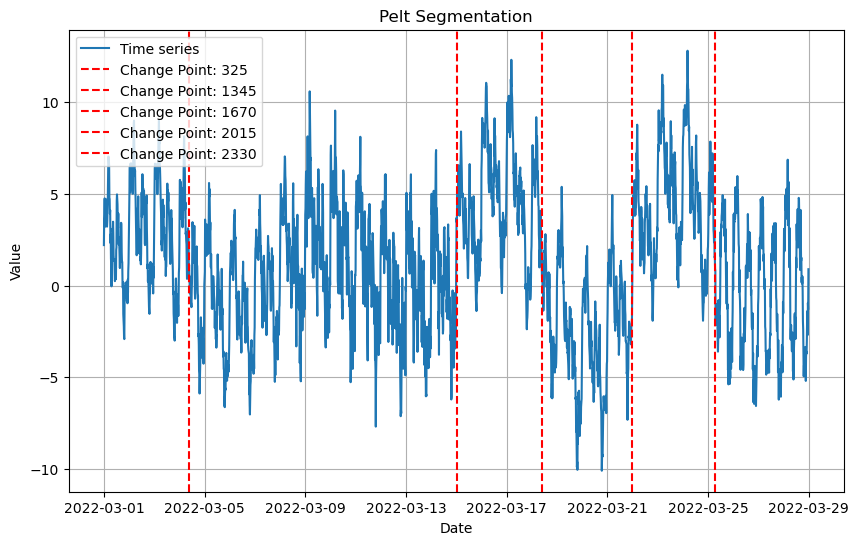

Change Points: [325, 1345, 1670, 2015, 2330, 2688]


In [49]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, series, label="Time series")
for cp in change_points[:-1]:  # Exclude last point (time series end)
    plt.axvline(df.index[cp], color='red', linestyle='--', label=f'Change Point: {cp}')
plt.title("Pelt Segmentation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Mostrar los puntos de cambio
print("Change Points:", change_points)

In [50]:
df.index[change_points[:-1]]

DatetimeIndex(['2022-03-04 09:15:00', '2022-03-15 00:15:00',
               '2022-03-18 09:30:00', '2022-03-21 23:45:00',
               '2022-03-25 06:30:00'],
              dtype='datetime64[ns]', freq=None)

In [51]:
# Divide time series 
segments = []
start = 0

for cp in change_points:
    segments.append(df[start:cp])
    start = cp

In [52]:
def moving_average(data, window_size=5):
    """
    Smooth a time series using moving average.

    Args:
        data: Time series as a numpy array.
        window_size: Size of the moving average window.

    Returns:
        Smoothed time series.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

In [53]:
smoothed_segments = []
for segment in segments:
    # Ensure segment is a proper copy to avoid modifying the original DataFrame
    segment = segment.copy()
    print_flush(f"Segment ~{segment.shape}")
    # Apply moving average smoothing
    smoothed_values = moving_average(segment[segment.columns[0]].values, window_size = enc_run.config['w'])

    # Assign smoothed values explicitly
    segment.loc[:, 'smoothed_value'] = smoothed_values
    smoothed_segments.append(segment)

# Combine all smoothed segments into a single DataFrame
df_smoothed = pd.concat(smoothed_segments)


Segment ~(325, 1)
Segment ~(1020, 1)
Segment ~(325, 1)
Segment ~(345, 1)
Segment ~(315, 1)
Segment ~(358, 1)


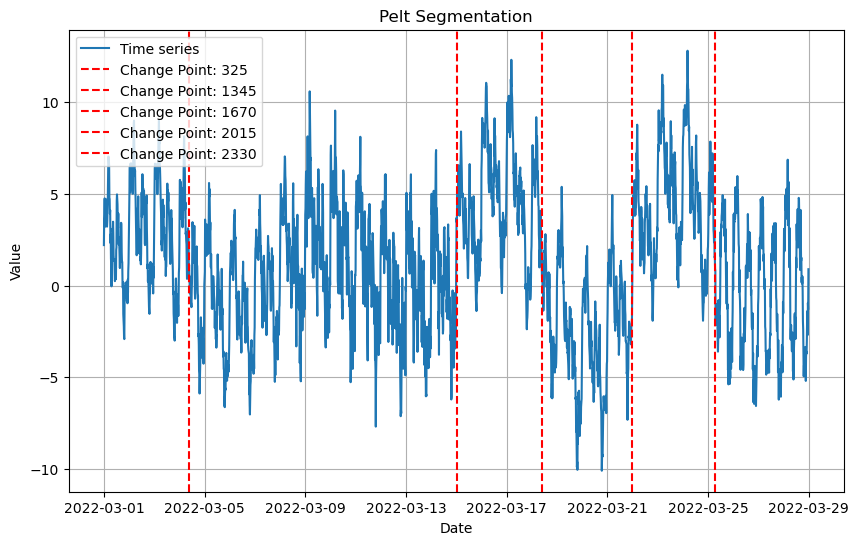

Change Points: [325, 1345, 1670, 2015, 2330, 2688]


In [54]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, series, label="Time series")
for cp in change_points[:-1]:  # Exclude last point (time series end)
    plt.axvline(df.index[cp], color='red', linestyle='--', label=f'Change Point: {cp}')
plt.title("Pelt Segmentation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Mostrar los puntos de cambio
print("Change Points:", change_points)

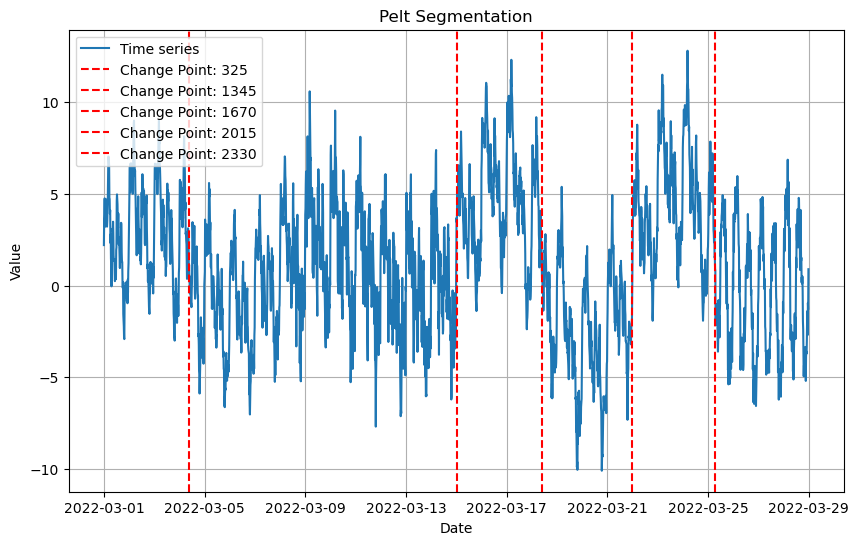

Change Points: [325, 1345, 1670, 2015, 2330, 2688]


In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df_smoothed.index, series, label="Time series")
for cp in change_points[:-1]:  # Exclude last point (time series end)
    plt.axvline(df_smoothed.index[cp], color='red', linestyle='--', label=f'Change Point: {cp}')
plt.title("Pelt Segmentation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Mostrar los puntos de cambio
print("Change Points:", change_points)

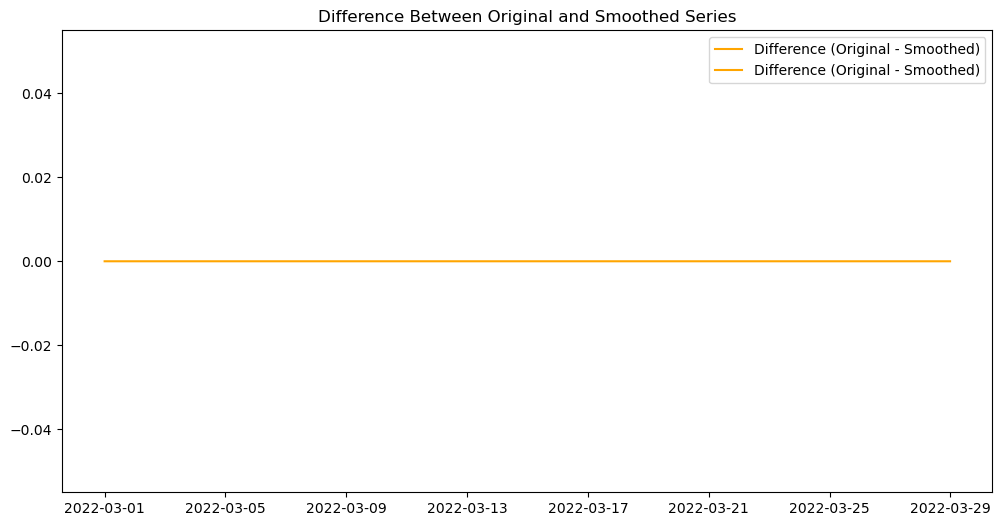

In [56]:
difference = df - df_smoothed

plt.figure(figsize=(12, 6))
plt.plot(difference, label='Difference (Original - Smoothed)', color='orange')
plt.title('Difference Between Original and Smoothed Series')
plt.legend()
plt.show()

/tmp/ipykernel_55903/3294051640.py:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df_smoothed.index, 'segment'] = df_smoothed['segment']


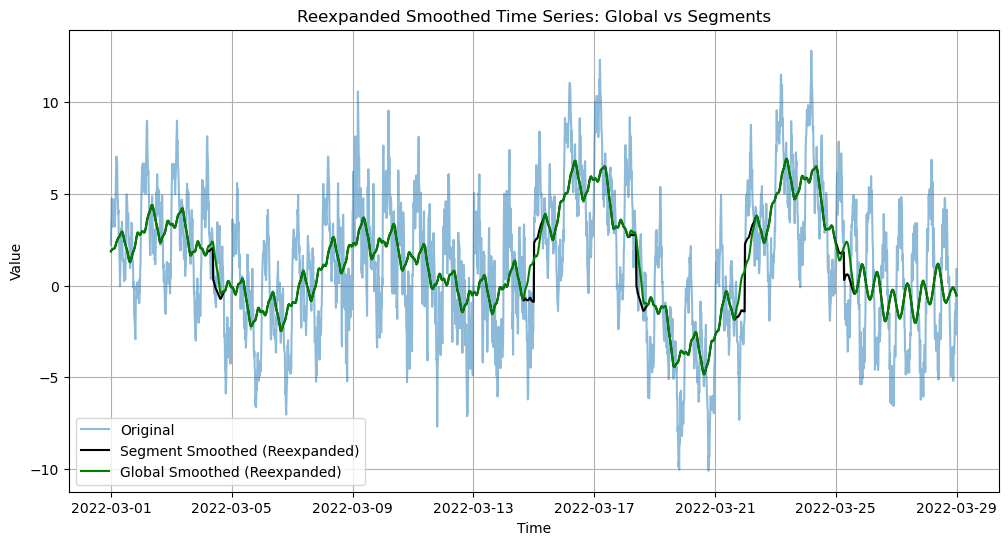

In [57]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

# Inicializar la lista de segmentos suavizados
smoothed_segments = []

# Suavizar cada segmento
for i, segment in enumerate(segments):
    # Hacer una copia explícita del segmento
    segment = segment.copy()

    # Etiquetar el segmento
    segment.loc[:, 'segment'] = i

    # Aplicar suavizado
    smoothed_values = moving_average(segment[segment.columns[0]].values, window_size=enc_run.config['w'])

    # Agregar valores suavizados al segmento con prefijo segment_
    segment.loc[:, 'segment_smoothed_value'] = smoothed_values

    # Agregar el segmento suavizado a la lista
    smoothed_segments.append(segment)

# Combinar todos los segmentos suavizados
df_smoothed = pd.concat(smoothed_segments)

# Combinar la información suavizada en el DataFrame original
df['segment'] = np.nan  # Inicializar columna para segmentación
df['segment_smoothed_value'] = np.nan  # Inicializar columna para valores suavizados

# Asignar valores suavizados por segmentos al DataFrame original
df.loc[df_smoothed.index, 'segment'] = df_smoothed['segment']
df.loc[df_smoothed.index, 'segment_smoothed_value'] = df_smoothed['segment_smoothed_value']

# Interpolación spline para reexpansión de suavizado por segmentos
valid_indices_segment = df.index[~df['segment_smoothed_value'].isna()]
valid_values_segment = df.loc[valid_indices_segment, 'segment_smoothed_value']
spline_segment = CubicSpline(valid_indices_segment, valid_values_segment, extrapolate=True)
df['segment_reexpanded_smoothed_value'] = spline_segment(df.index)

# Suavizado global y reexpansión
df['smoothed_value'] = moving_average(df[df.columns[0]].values, window_size=enc_run.config['w'])

# Interpolación spline para reexpansión del suavizado global
valid_indices_global = df.index[~df['smoothed_value'].isna()]
valid_values_global = df.loc[valid_indices_global, 'smoothed_value']
spline_global = CubicSpline(valid_indices_global, valid_values_global, extrapolate=True)
df['reexpanded_smoothed_value'] = spline_global(df.index)

# Visualización
plt.figure(figsize=(12, 6))

# Serie original
plt.plot(df.index, df[df.columns[0]], label="Original", alpha=0.5)

# Suavizado por segmentos (reexpandido)
plt.plot(df.index, df['segment_reexpanded_smoothed_value'], label="Segment Smoothed (Reexpanded)", color='black')

# Suavizado global (reexpandido)
plt.plot(df.index, df['reexpanded_smoothed_value'], label="Global Smoothed (Reexpanded)", color='green')

plt.title("Reexpanded Smoothed Time Series: Global vs Segments")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


In [58]:
df.head()

,Seasonal time series w/ noise,segment,segment_smoothed_value,segment_reexpanded_smoothed_value,smoothed_value,reexpanded_smoothed_value
2022-03-01 00:00:00,2.210769,0,1.870333,1.870333,1.870333,1.870333
2022-03-01 00:15:00,3.480337,0,1.910430,1.910430,1.910430,1.910430
2022-03-01 00:30:00,3.862855,0,1.933666,1.933666,1.933666,1.933666
2022-03-01 00:45:00,4.758258,0,1.952496,1.952496,1.952496,1.952496
2022-03-01 01:00:00,3.205716,0,1.971493,1.971493,1.971493,1.971493


In [59]:
enc_input_smoothed, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df['segment_reexpanded_smoothed_value'])
print(enc_input.shape)
embs_smoothed = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input_smoothed, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)

(2617, 1, 72)
[1] --> get_enc_embs_set_stride_set_batch_size
[1] get_enc_embs_set_stride_set_batch_size | Moment | True
[1] get_acts_moment | Trial 1 | x_enc ~ torch.Size([2617, 1, 72])
[1] get_acts_moment | Trial 1 | embs ~ torch.Size([2617, 1, 9, 512])
[1] get_enc_embs_set_stride_set_batch_size | Before moving to CPU | embs~(2617, 512)
[1] get_enc_embs_set_stride_set_batch_size | embs~(2617, 512) -->


# Dimensionality reduction

In [60]:
config_dr, _ = get_artifact_config_dimensionality_reduction(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/04-dimensionality_reduction.yaml
Getting content./config/04-dimensionality_reduction.yaml
... About to replace includes with content
Load content./config/04-dimensionality_reduction.yaml
enc_artifact: mi-santamaria/deepvats/moment-small-embedding:latest


In [81]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}
pca_params = {
    #'copy'  : False,
    #'handle': None,
    #'iterate_power' : 15,
    'n_components': 8,
    'random_state': 1234,
    #'svd_solver' : 'auto',
    #'tol': 1e-07,
    #'verbose': False,
    #'whiten': False,
    #'output_type': 'input'
}

In [62]:
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_smoothed_no_nan = embs_smoothed[~np.isnan(embs_smoothed).any(axis=1)]

In [82]:
prjs          = get_PCA_UMAP_prjs(
    input_data = embs_no_nan, 
    cpu=False, 
    check_memory_usage = False,
    verbose = 2,
    pca_kwargs = pca_params,
    umap_kwargs = umap_params
)
prjs_smoothed = get_PCA_UMAP_prjs(
    embs_smoothed_no_nan, 
    cpu=False, 
    pca_kwargs = pca_params,
    umap_kwargs = umap_params
)

About to compute PCA input_data~(2617, 512)
PCA prjs~(2617, 8)
About to compute UMAP
--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234}
96f6941df6a86ec1d79e57688712e462
GPU | Used mem: 14
GPU | Used mem: 48
GPU | Memory Usage: [█████---------------] 29%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7f379c62bae0>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': None, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'spectral', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': -1, 'target_weight': 0.5, 'target_metric': 'categorical', 'hash_input': False, 'random_state': 1234, 'callback': None, 'metric': 'euclidean', 'metric_kwds': None, 'precomputed_knn': None}
------- reducer --------

In [64]:
import hdbscan

In [83]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 100,
    'min_samples' : 15,
    'cluster_selection_epsilon' : 0.01,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_smoothed = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_smoothed)
clusters_labels = clusters.labels_
clusters_smoothed_labels = clusters.labels_
print(np.unique(clusters_labels))

[0 1 2 3]


In [66]:
#| export
# Color cluster & lines out
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

[ 0  3  4 -1  2  1]


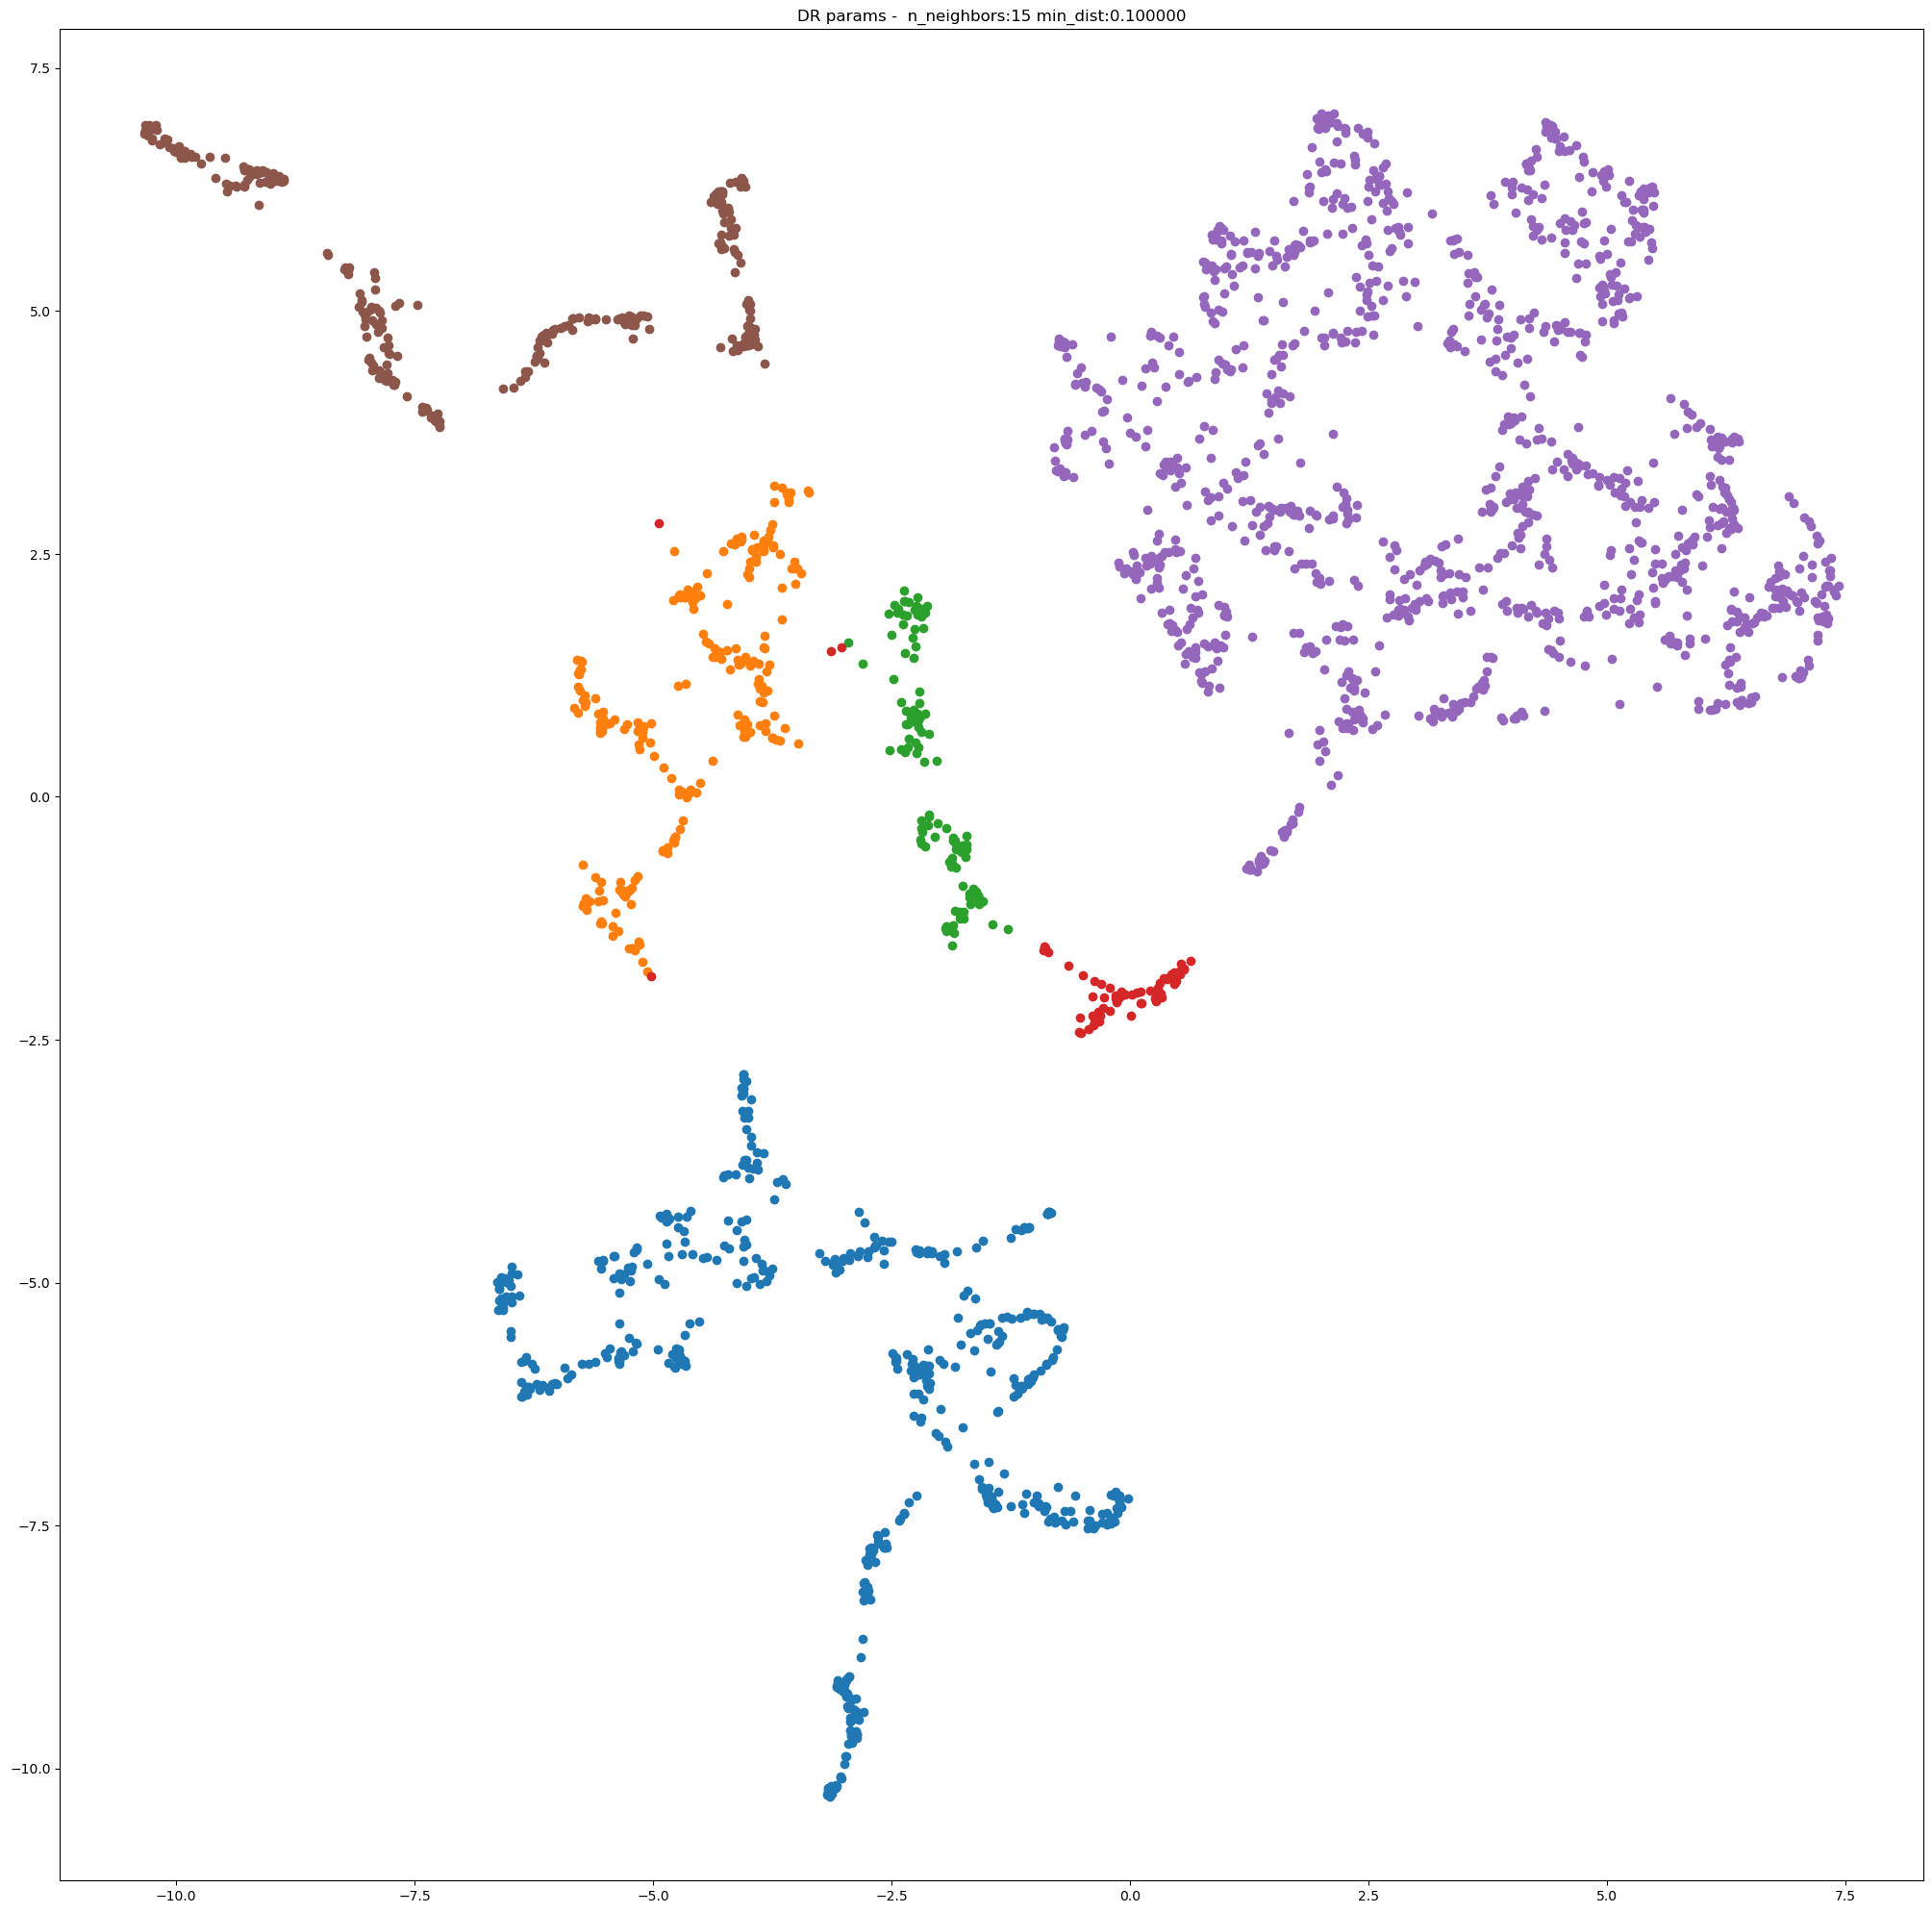

In [67]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

[ 0  3  4 -1  2  1]


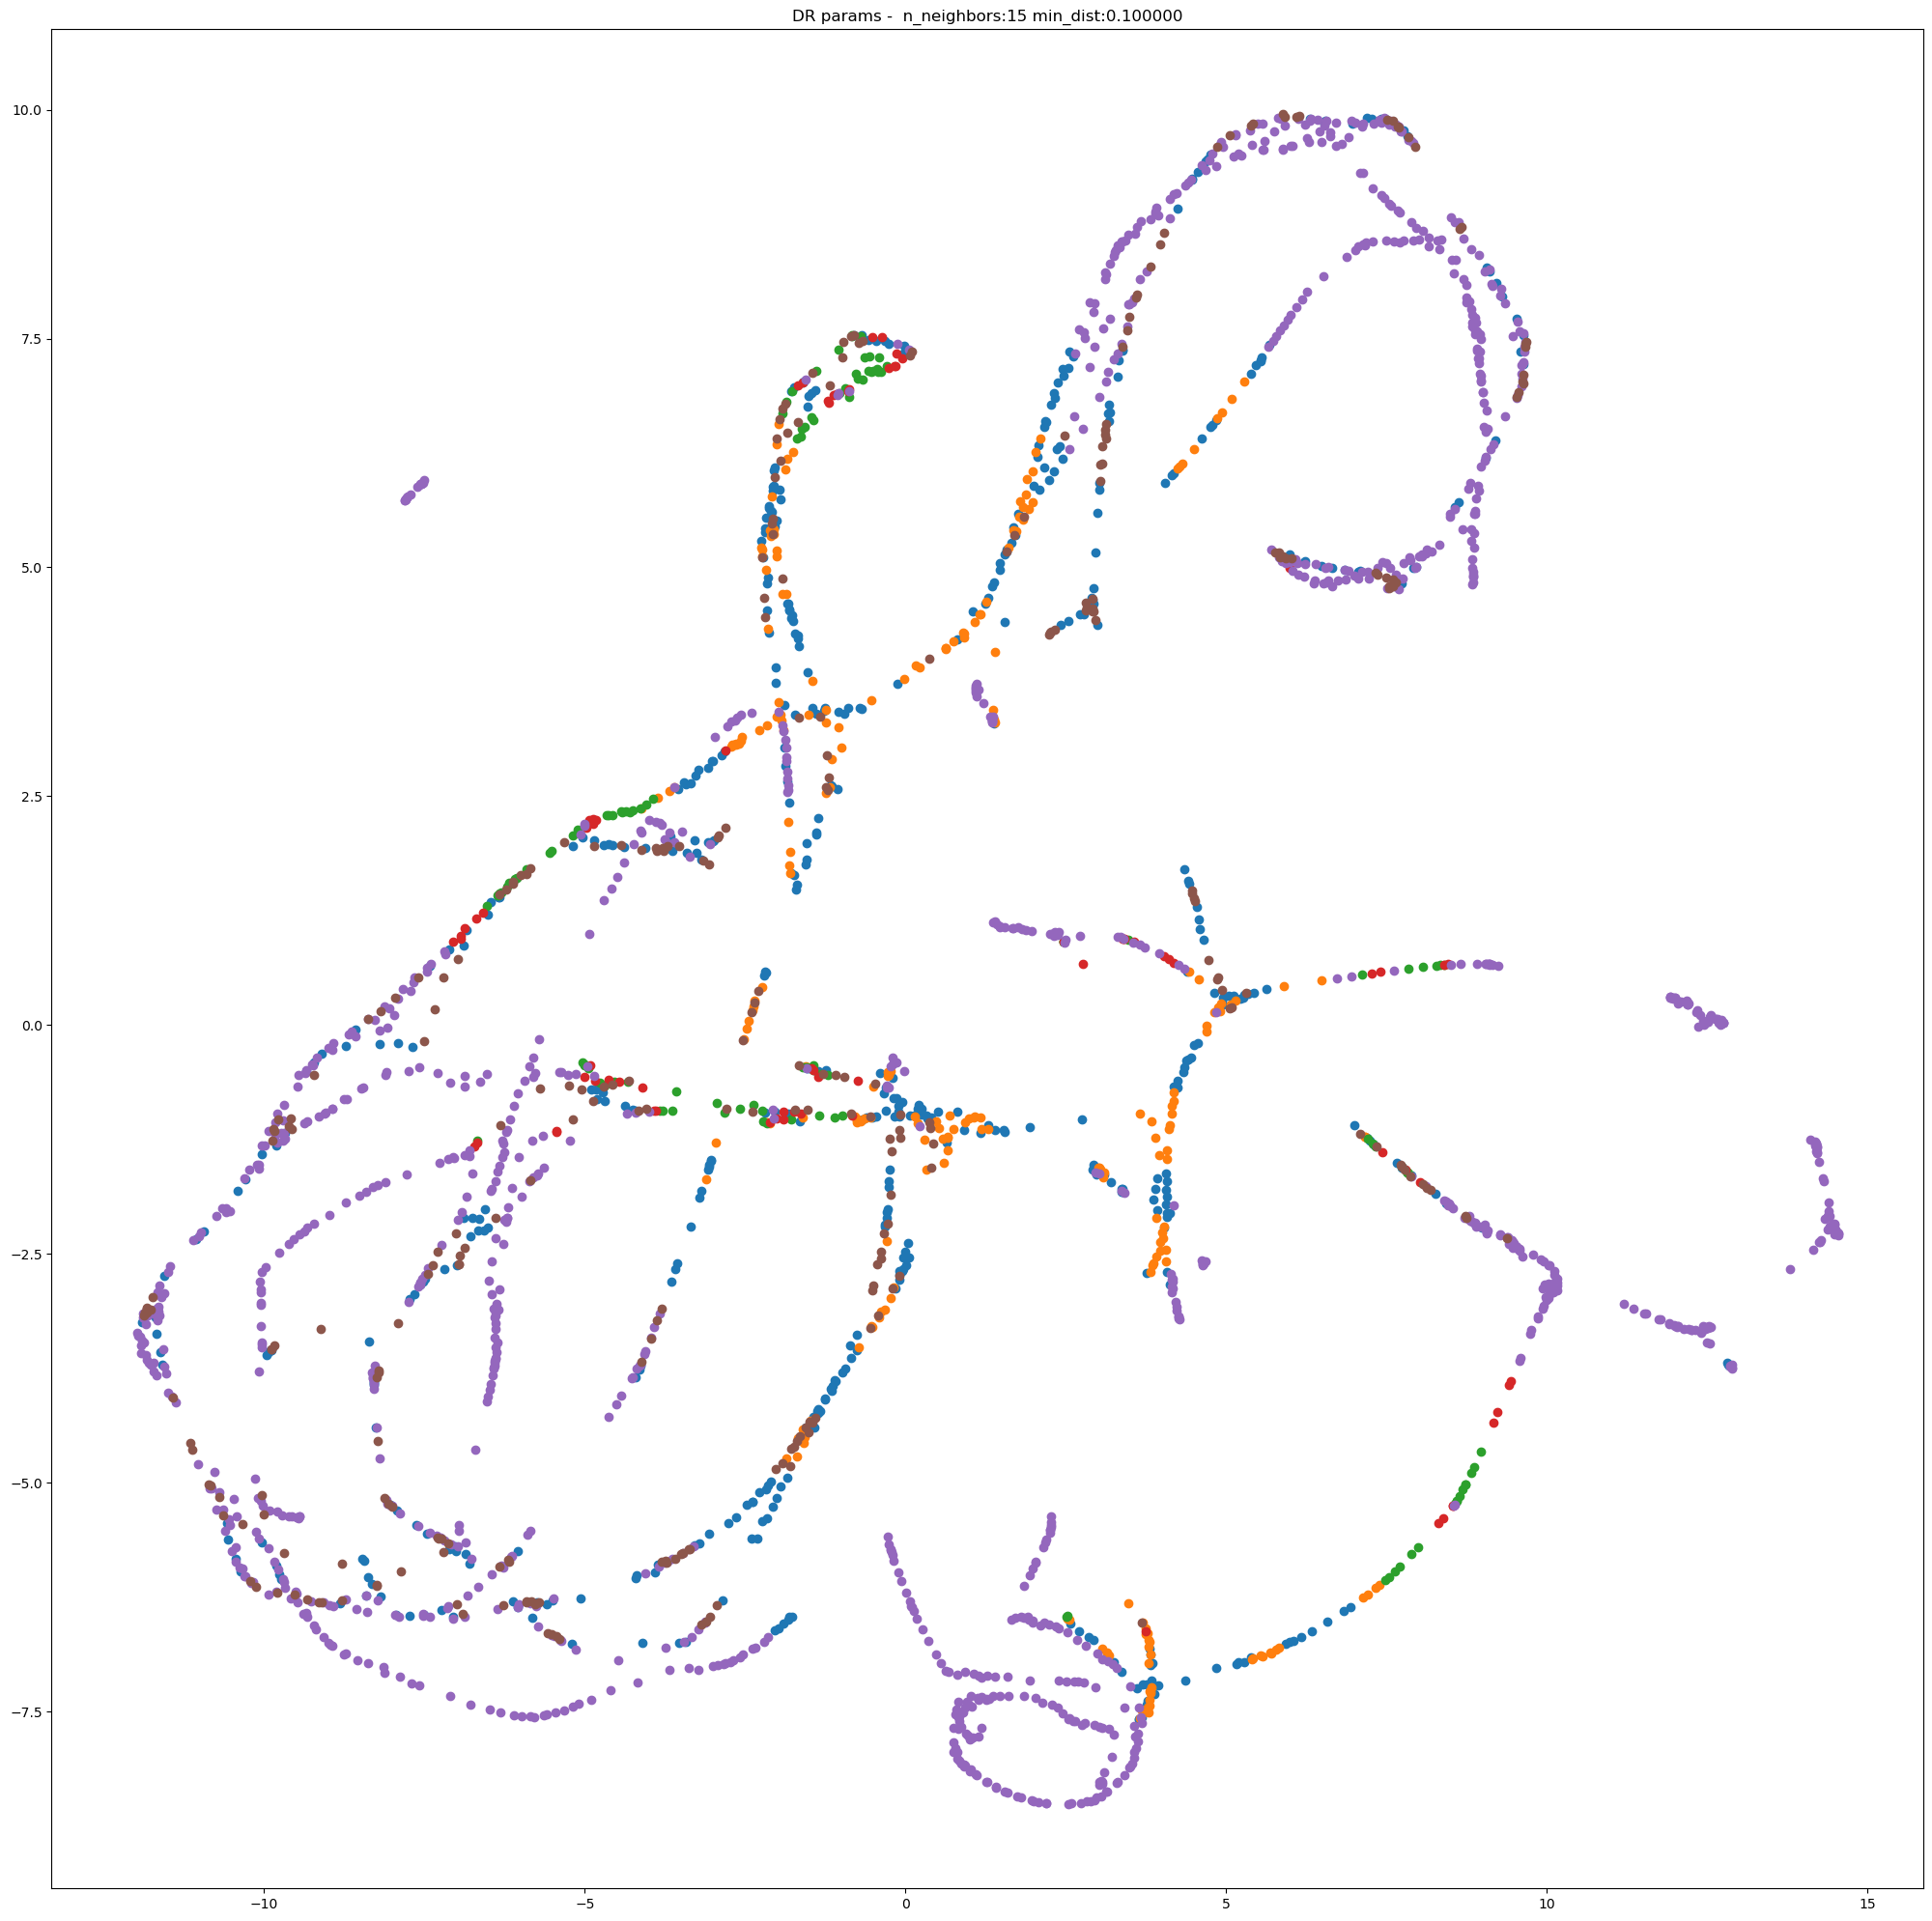

In [68]:
prjs_plt_smoothed = plot_projections_clusters(prjs_smoothed, clusters_smoothed_labels, umap_params)

# Visualization as time series

In [69]:
def get_window_indices(idx, wlen, stride):
    start_idx = ((idx - 1) * stride)
    end_idx = start_idx + wlen
    indices = np.array(range(start_idx, end_idx))
    return indices

In [70]:
len(clusters_labels)

2617

In [71]:
#| hide
wlen = enc_run.config['w']
stride = enc_run.config['stride']
indices = np.array( [  get_window_indices(i, wlen, stride) for i in range(len(clusters_labels)) ] )
print(indices.shape)

(2617, 72)


In [72]:
#| export
def plot_time_series_clusters(values, clusters_labels, stride, wlen):
    series_length = len(values)
    
    # Calcular todos los índices para cada cluster
    indices = np.array([get_window_indices(i + 1, wlen, stride) for i in range(len(clusters_labels))])
    print(f"Shape de los índices calculados: {indices.shape}")
    
    # Graficar la serie por clusters
    plt.figure(figsize=(15, 6))
    unique_clusters = np.unique(clusters_labels)
    for cluster in unique_clusters:
        # Seleccionar índices de este cluster
        cluster_indices = np.where(clusters_labels == cluster)[0]
        cluster_points = np.unique(indices[cluster_indices])  # Obtener puntos únicos para el cluster
        cluster_points = cluster_points[cluster_points < series_length]  # Filtrar índices válidos
        plt.plot(cluster_points, values[cluster_points], label=f"Cluster {cluster}")
    
    plt.title("Serie Temporal Coloreada por Cluster")
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid()
    plt.show()

Shape de los índices calculados: (2617, 72)


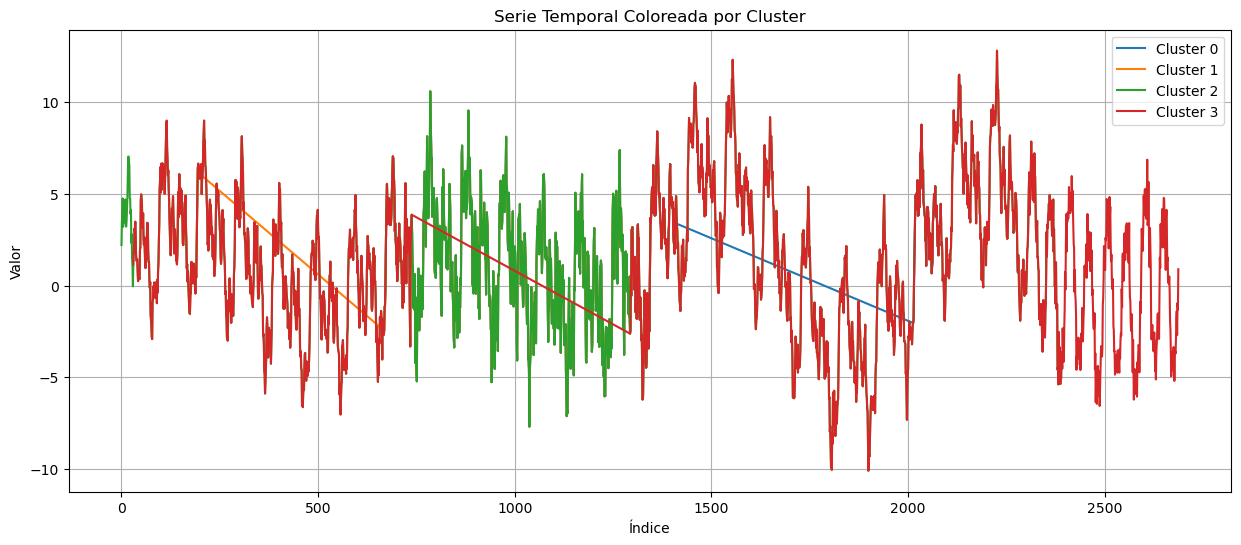

In [84]:
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])

Shape de los índices calculados: (2617, 72)


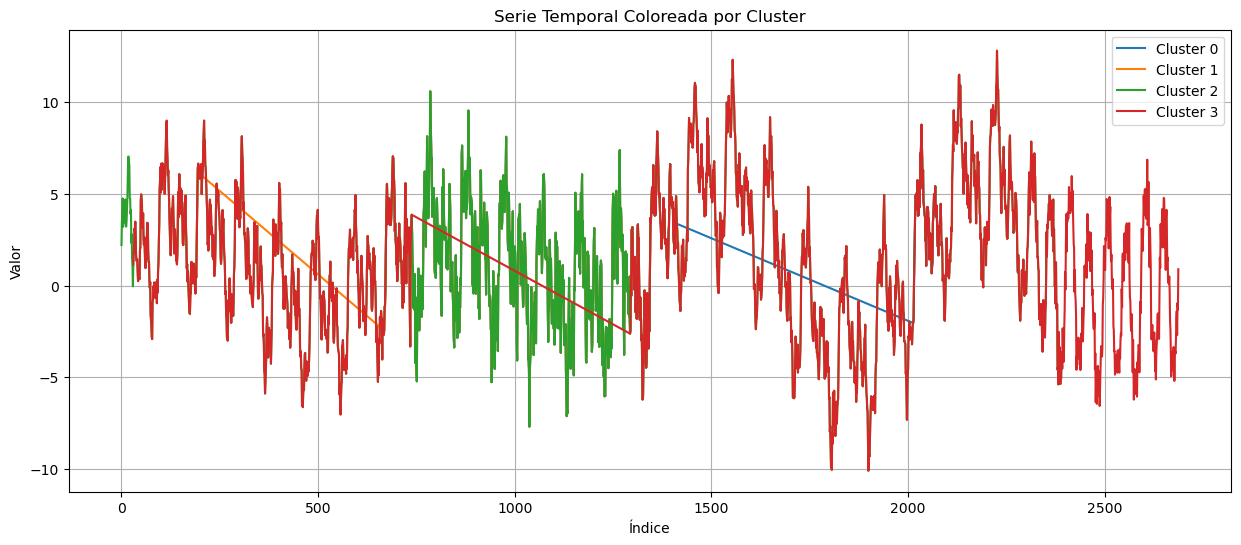

In [85]:
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

In [75]:
def plot_time_series_clusters_shadow(values, clusters_labels, stride, wlen):
    series_length = len(values)
    
    # Calcular todos los índices para cada cluster
    indices = np.array([get_window_indices(i + 1, wlen, stride) for i in range(len(clusters_labels))])
    print(f"Shape de los índices calculados: {indices.shape}")
    
    # Graficar la serie con sombreado por cluster
    plt.figure(figsize=(15, 6))
    unique_clusters = np.unique(clusters_labels)
    for cluster in unique_clusters:
        # Seleccionar índices de este cluster
        cluster_indices = np.where(clusters_labels == cluster)[0]
        cluster_points = np.unique(indices[cluster_indices])  # Obtener puntos únicos para el cluster
        cluster_points = cluster_points[cluster_points < series_length]  # Filtrar índices válidos
        
        # Aplicar sombreado al área del cluster
        plt.fill_between(cluster_points, values[cluster_points], alpha=0.5, label=f"Cluster {cluster}")
    
    plt.title("Serie Temporal Sombreada por Cluster")
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid()
    plt.show()

Shape de los índices calculados: (2617, 72)


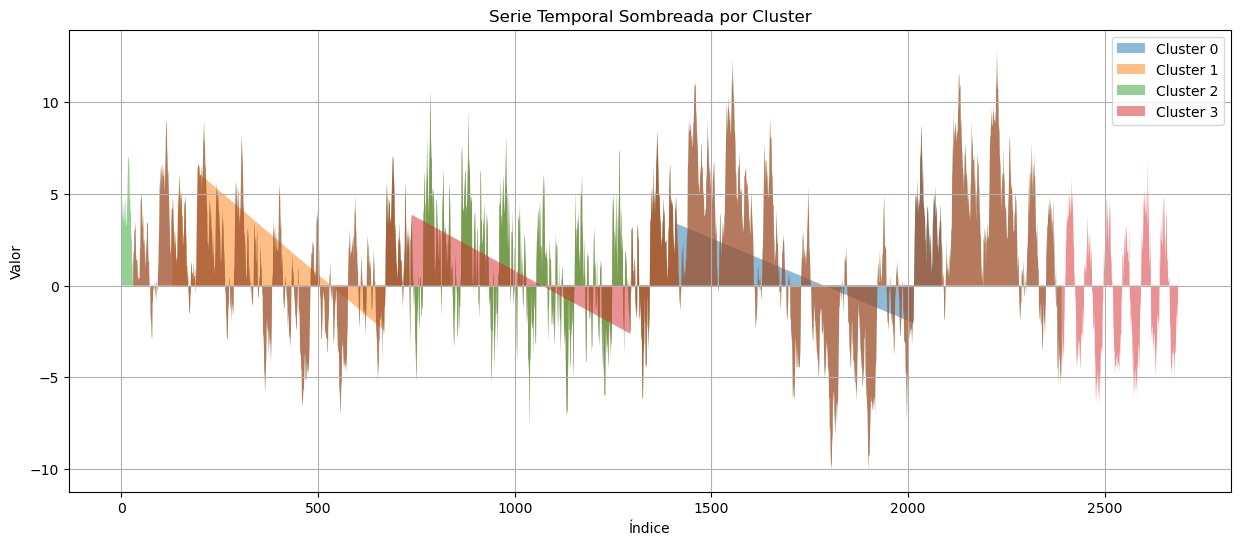

In [86]:
plot_time_series_clusters_shadow(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])

Shape de los índices calculados: (2617, 72)


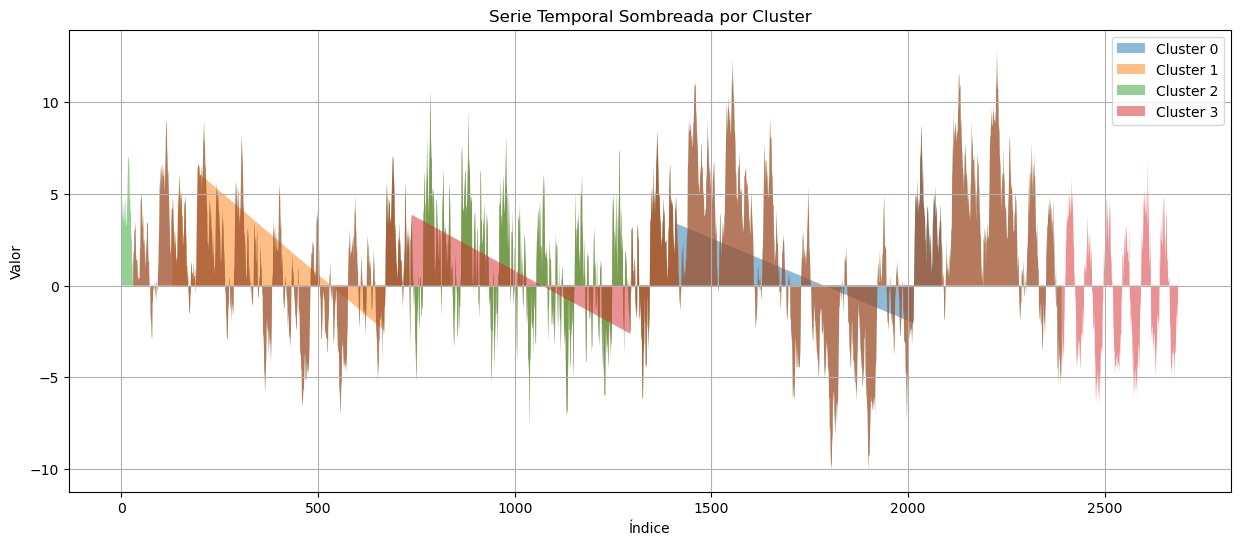

In [87]:
plot_time_series_clusters_shadow(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

In [78]:
# Función para agrupar ventanas consecutivas
def merge_intersections(intersection):
    merged = []
    if len(intersection) == 0:
        return merged
    start = intersection[0]
    for i in range(1, len(intersection)):
        if intersection[i] <= intersection[i - 1] + 1:  # Rango consecutivo
            continue
        else:
            merged.append((start, intersection[i - 1]))
            start = intersection[i]
    merged.append((start, intersection[-1]))  # Agregar el último rango
    return merged

# Función principal
def plot_time_series_clusters_with_intersections(values, clusters_labels, stride, wlen):
    series_length = len(values)
    
    # Calcular todos los índices para cada cluster
    indices = np.array([get_window_indices(i + 1, wlen, stride) for i in range(len(clusters_labels))])
    print(f"Shape de los índices calculados: {indices.shape}")
    
    # Graficar la serie con sombreado por cluster
    plt.figure(figsize=(15, 6))
    unique_clusters = np.unique(clusters_labels)
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters_labels == cluster)[0]
        cluster_points = np.unique(indices[cluster_indices])  # Obtener puntos únicos para el cluster
        cluster_points = cluster_points[cluster_points < series_length]  # Filtrar índices válidos
        
        # Aplicar sombreado al área del cluster
        plt.fill_between(cluster_points, values[cluster_points], alpha=0.5, label=f"Cluster {cluster}")
    
    plt.title("Serie Temporal Sombreada por Cluster")
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Calcular intersecciones entre clusters
    cluster_intersections = []
    for i, cluster_a in enumerate(unique_clusters):
        for j, cluster_b in enumerate(unique_clusters):
            if i < j:  # Evitar duplicados y autocomparaciones
                indices_a = np.unique(indices[np.where(clusters_labels == cluster_a)[0]])
                indices_b = np.unique(indices[np.where(clusters_labels == cluster_b)[0]])
                
                intersection = np.intersect1d(indices_a, indices_b)
                if len(intersection) > 0:
                    #merged_ranges = merge_intersections(intersection)
                    cluster_intersections.append({
                        'Cluster A': cluster_a,
                        'Cluster B': cluster_b,
                        'Intersection Count': len(intersection),
                     #   'Merged Ranges': merged_ranges
                    })
    
    # Convertir a DataFrame
    intersections_df = pd.DataFrame(cluster_intersections)
    return intersections_df

Shape de los índices calculados: (2617, 72)


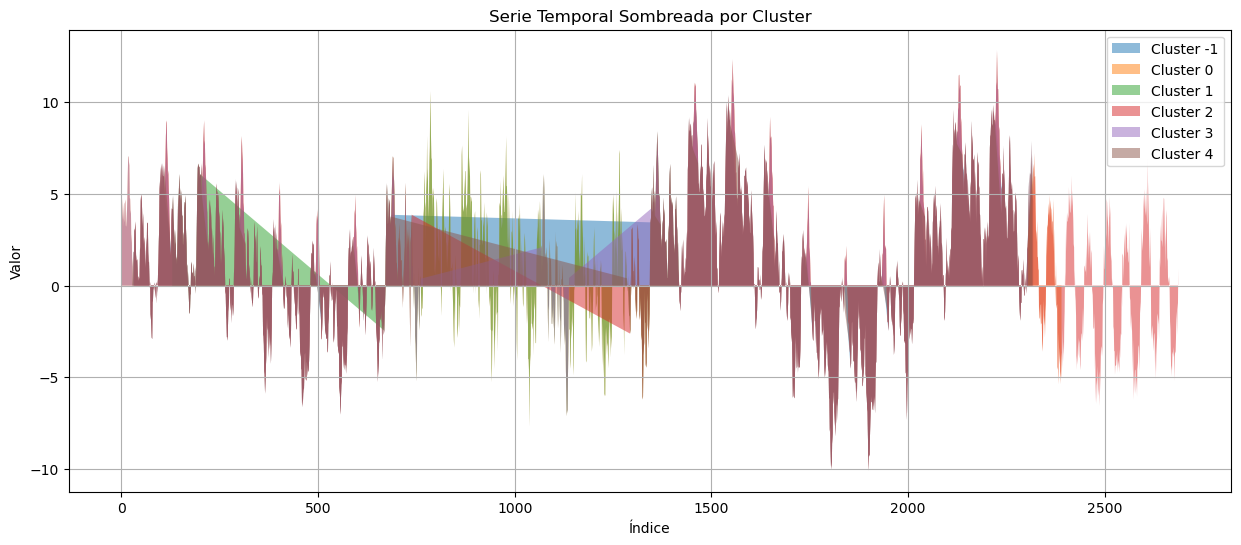

,Cluster A,Cluster B,Intersection Count
0,-1,0,1410
1,-1,1,162
2,-1,2,1423
3,-1,3,1410
4,-1,4,1360
5,0,1,821
6,0,2,1790
7,0,3,1788
8,0,4,1440
9,1,2,267


In [79]:
plot_time_series_clusters_with_intersections(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])

Shape de los índices calculados: (2617, 72)


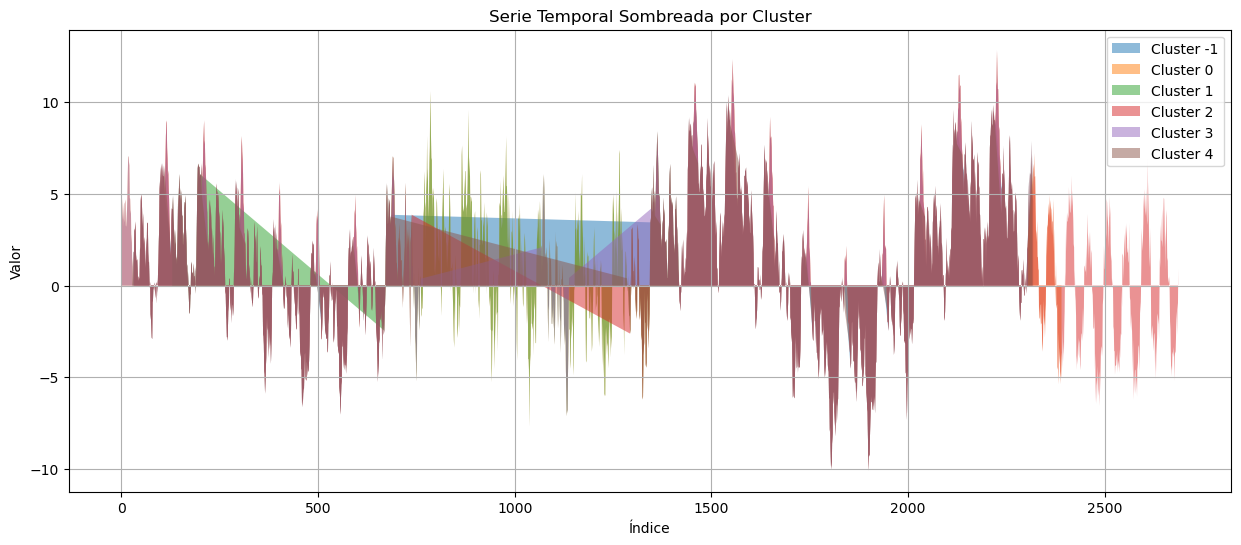

,Cluster A,Cluster B,Intersection Count
0,-1,0,1410
1,-1,1,162
2,-1,2,1423
3,-1,3,1410
4,-1,4,1360
5,0,1,821
6,0,2,1790
7,0,3,1788
8,0,4,1440
9,1,2,267


In [80]:
plot_time_series_clusters_with_intersections(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

In [88]:
#| export
def plot_time_series_clusters(values, clusters_labels, stride, wlen):
    series_length = len(values)
    
    # Calcular todos los índices para cada cluster
    indices = np.array([get_window_indices(i + 1, wlen, stride) for i in range(len(clusters_labels))])
    print(f"Shape de los índices calculados: {indices.shape}")
    
    # Obtener clusters únicos
    unique_clusters = np.unique(clusters_labels)
    num_clusters = len(unique_clusters)
    
    # Configurar la distribución de los gráficos en dos columnas
    num_rows = (num_clusters + 1) // 2  # Calcular el número de filas
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5), sharex=True, sharey=True)
    axes = axes.flatten()  # Aplanar el arreglo de ejes
    
    for idx, cluster in enumerate(unique_clusters):
        ax = axes[idx]
        
        # Seleccionar índices de este cluster
        cluster_indices = np.where(clusters_labels == cluster)[0]
        cluster_points = np.unique(indices[cluster_indices])  # Obtener puntos únicos para el cluster
        cluster_points = cluster_points[cluster_points < series_length]  # Filtrar índices válidos
        
        # Graficar los puntos del cluster
        ax.plot(cluster_points, values[cluster_points], label=f"Cluster {cluster}")
        ax.set_title(f"Cluster {cluster}")
        ax.set_xlabel("Índice")
        ax.set_ylabel("Valor")
        ax.legend()
        ax.grid()
    
    # Eliminar subplots vacíos si hay un número impar de clusters
    for idx in range(len(unique_clusters), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


Shape de los índices calculados: (2617, 72)


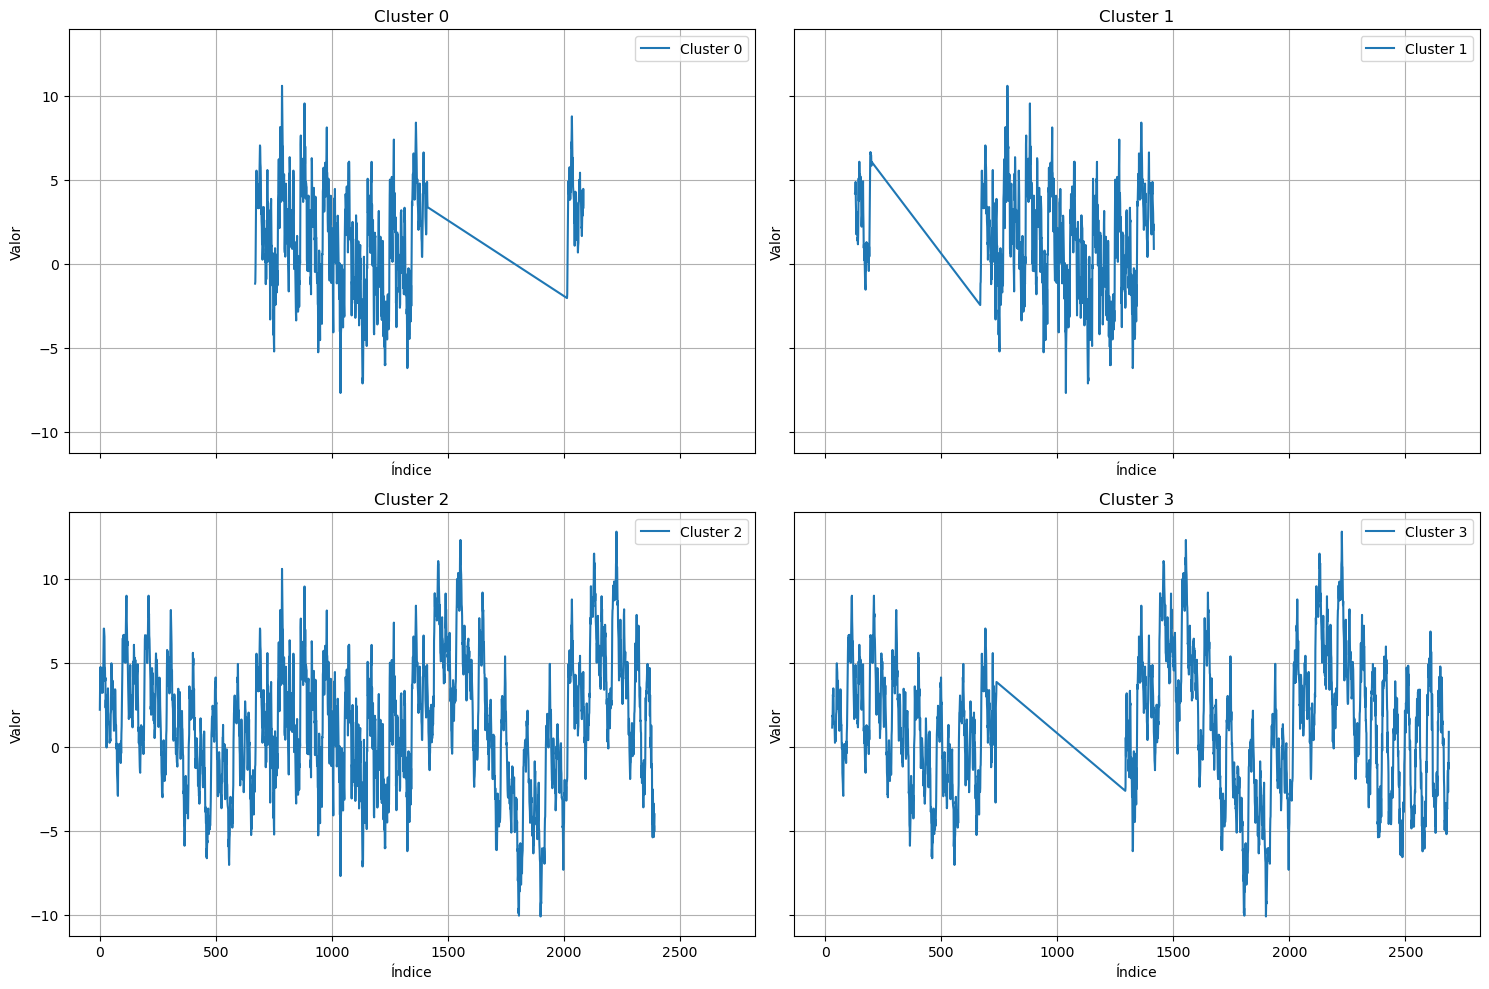

In [89]:
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])

Shape de los índices calculados: (2617, 72)


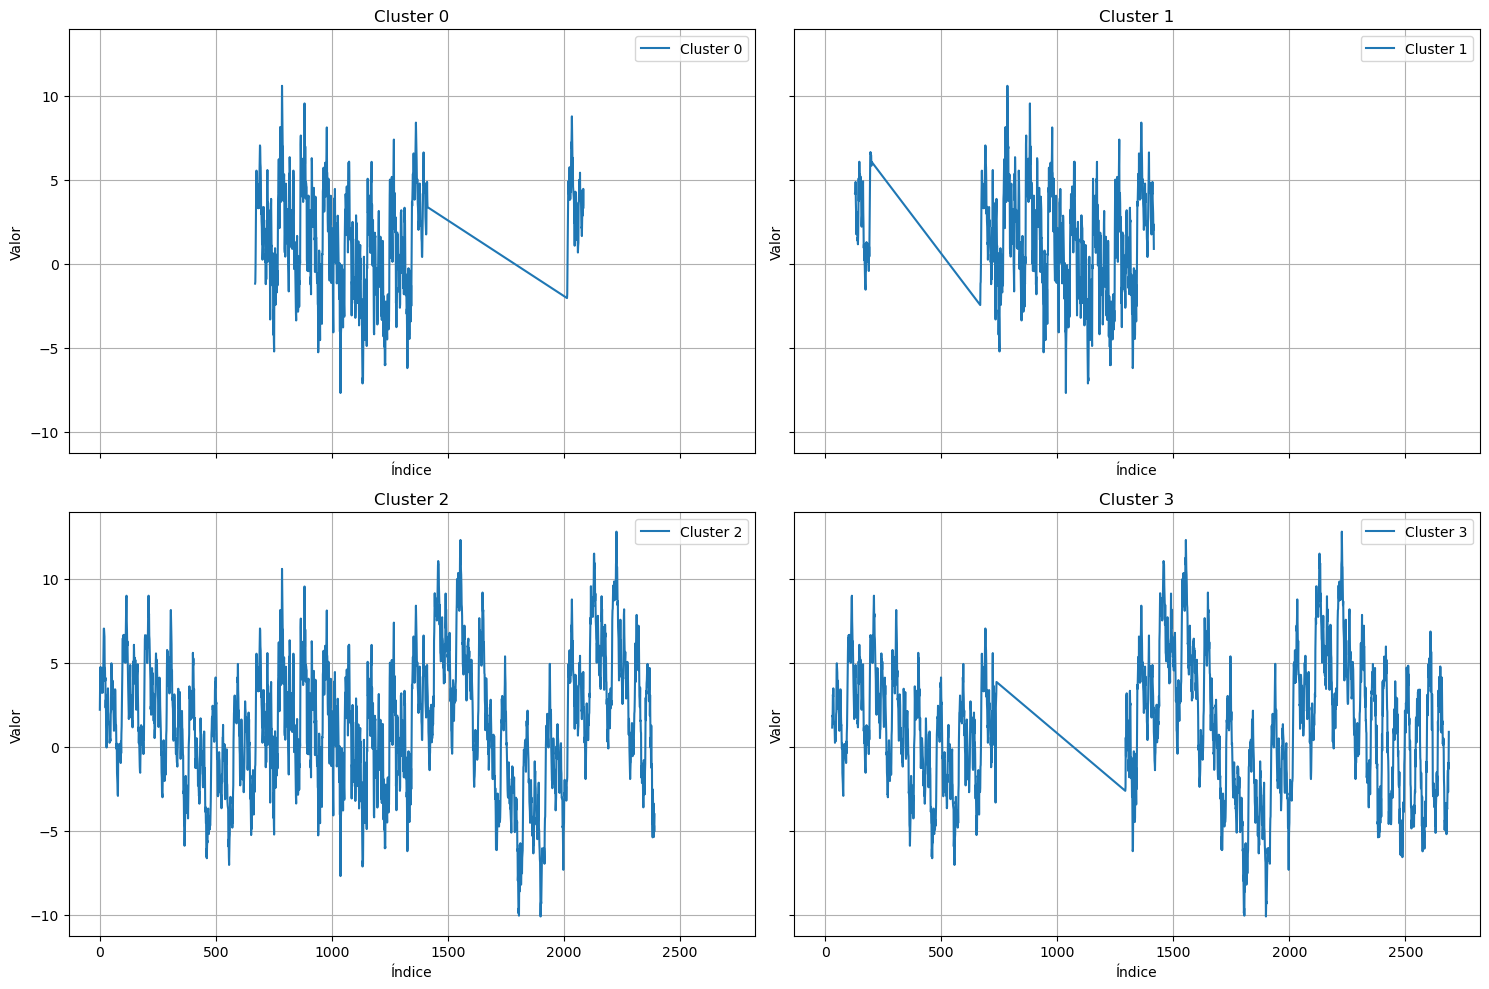

In [90]:
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

Few shot

In [93]:
result = fine_tune_moment_(
    X                             = df['segment_reexpanded_smoothed_value'],
    enc_learn                     = enc_learner, 
    stride                        = 1,      
    batch_size                    = enc_run.config['batch_size'],
    cpu                           = False, 
    to_numpy                      = True, 
    verbose                       = 0, 
    time_flag                     = False,
    #n_windows                     = 32,
    #n_windows_percent             = 0.8, # Enmascaro el parte del entrenamiento
    window_mask_percent           = enc_run.config['r'],
    training_percent              = 0.3, # Entreno con parte de los datos
    validation_percent            = 0.3, # Evalúo con parte de los datos
    num_epochs                    = 1,
    shot                          = True,
    eval_pre                      = False,
    eval_post                     = False,
    lr_scheduler_flag             = True,
    #lr_scheduler_name             = "",
    lr                            = 1e-3,
    lr_scheduler_num_warmup_steps = 0,
    window_sizes                  = [54,72, 300],
    n_window_sizes                = 5,
    full_dataset                  = True,
    window_sizes_offset           = 0.05,
    windows_min_distance          = 5,
    print_to_path                 = False,
    print_path                    ="~/data/logs.txt",
    print_mode                    = 'w',
    use_moment_masks              = False,
    mask_stateful                 = enc_run.config['mask_stateful'],
    mask_future                   = enc_run.config['mask_future'],
    mask_sync                     = enc_run.config['mask_sync']
)

[0] fine_tune_moment_single | Train | wlen 96


  0%|          | 0/49 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 67


  0%|          | 0/50 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 72


  0%|          | 0/50 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 300


  0%|          | 0/45 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 48


  0%|          | 0/50 [00:00<?, ?it/s]

In [97]:
enc_learner = result[-1]
embs = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)
embs_smoothed = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input_smoothed, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)

[1] --> get_enc_embs_set_stride_set_batch_size
[1] get_enc_embs_set_stride_set_batch_size | Moment | True
[1] get_acts_moment | Trial 1 | x_enc ~ torch.Size([2617, 1, 72])
[1] get_acts_moment | Trial 1 | embs ~ torch.Size([2617, 1, 9, 512])
[1] get_enc_embs_set_stride_set_batch_size | Before moving to CPU | embs~(2617, 512)
[1] get_enc_embs_set_stride_set_batch_size | embs~(2617, 512) -->
[1] --> get_enc_embs_set_stride_set_batch_size
[1] get_enc_embs_set_stride_set_batch_size | Moment | True
[1] get_acts_moment | Trial 1 | x_enc ~ torch.Size([2617, 1, 72])
[1] get_acts_moment | Trial 1 | embs ~ torch.Size([2617, 1, 9, 512])
[1] get_enc_embs_set_stride_set_batch_size | Before moving to CPU | embs~(2617, 512)
[1] get_enc_embs_set_stride_set_batch_size | embs~(2617, 512) -->


In [103]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}
pca_params = {
    #'copy'  : False,
    #'handle': None,
    #'iterate_power' : 15,
    'n_components': 5,
    'random_state': 1234,
    #'svd_solver' : 'auto',
    #'tol': 1e-07,
    #'verbose': False,
    #'whiten': False,
    #'output_type': 'input'
}
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_smoothed_no_nan = embs_smoothed[~np.isnan(embs_smoothed).any(axis=1)]
prjs          = get_PCA_UMAP_prjs(
    input_data = embs_no_nan, 
    cpu=False, 
    check_memory_usage = False,
    verbose = 2,
    pca_kwargs = pca_params,
    umap_kwargs = umap_params
)
prjs_smoothed = get_PCA_UMAP_prjs(
    embs_smoothed_no_nan, 
    cpu=False, 
    pca_kwargs = pca_params,
    umap_kwargs = umap_params
)
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 100,
    'min_samples' : 15,
    'cluster_selection_epsilon' : 0.01,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_smoothed = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_smoothed)
clusters_labels = clusters.labels_
clusters_smoothed_labels = clusters.labels_
print(np.unique(clusters_labels))

About to compute PCA input_data~(2617, 512)
PCA prjs~(2617, 5)
About to compute UMAP
--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234}
47e11d8c67024eb189d0e07b2829c030
GPU | Used mem: 13
GPU | Used mem: 48
GPU | Memory Usage: [█████---------------] 27%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7f37afca2c40>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': None, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'spectral', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': -1, 'target_weight': 0.5, 'target_metric': 'categorical', 'hash_input': False, 'random_state': 1234, 'callback': None, 'metric': 'euclidean', 'metric_kwds': None, 'precomputed_knn': None}
------- reducer --------

Shape de los índices calculados: (2617, 72)


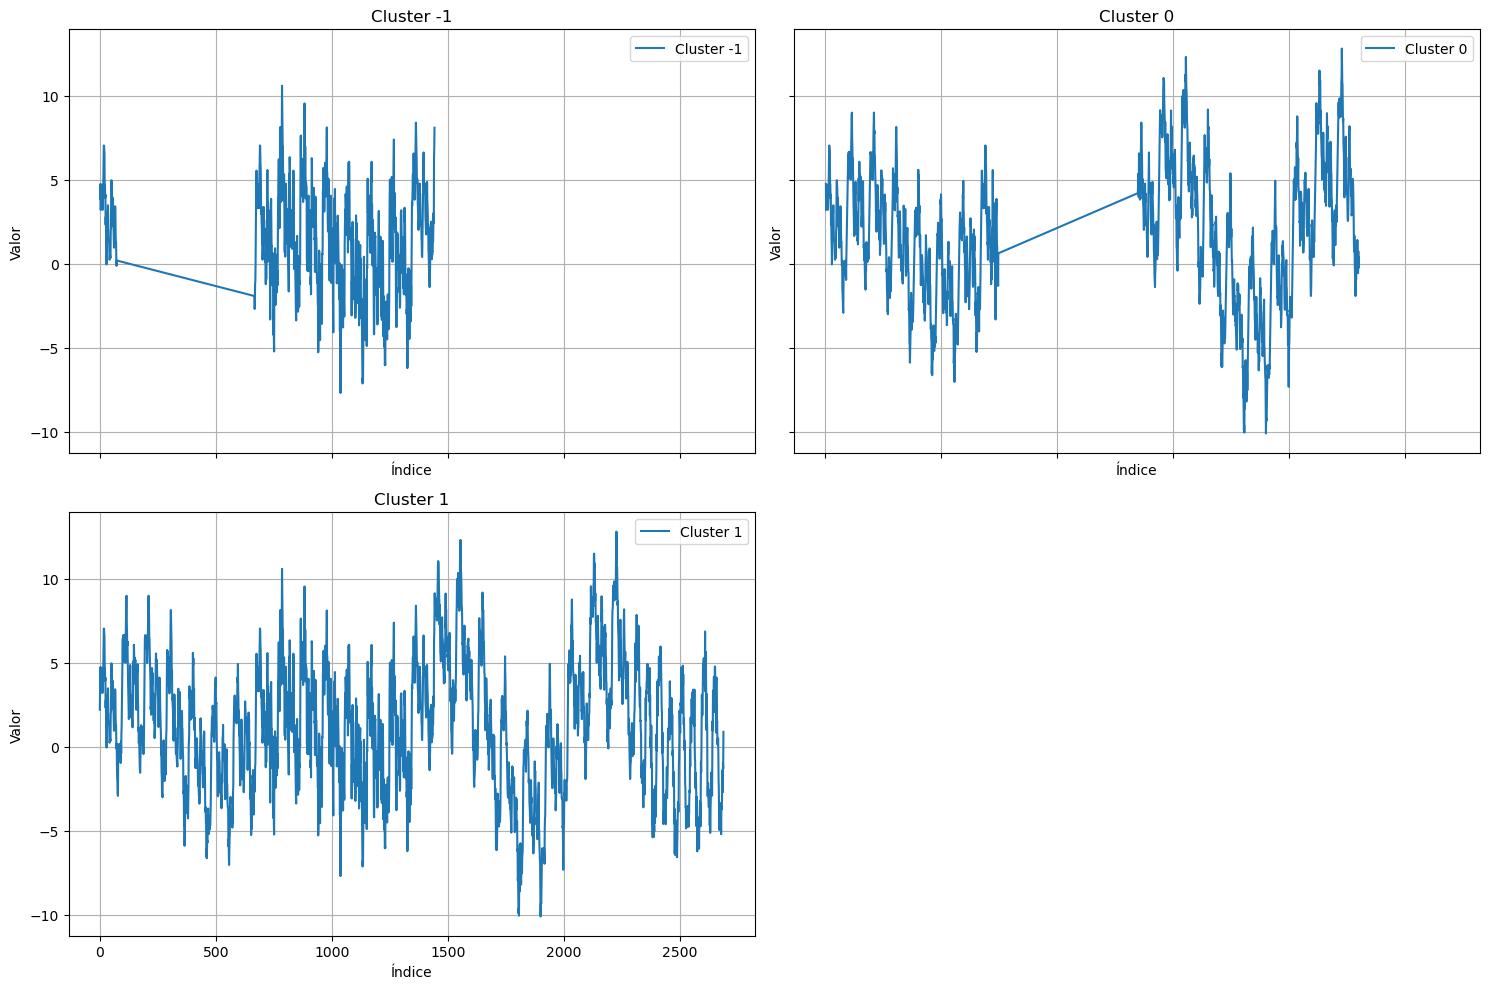

In [104]:
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])

Shape de los índices calculados: (2617, 72)


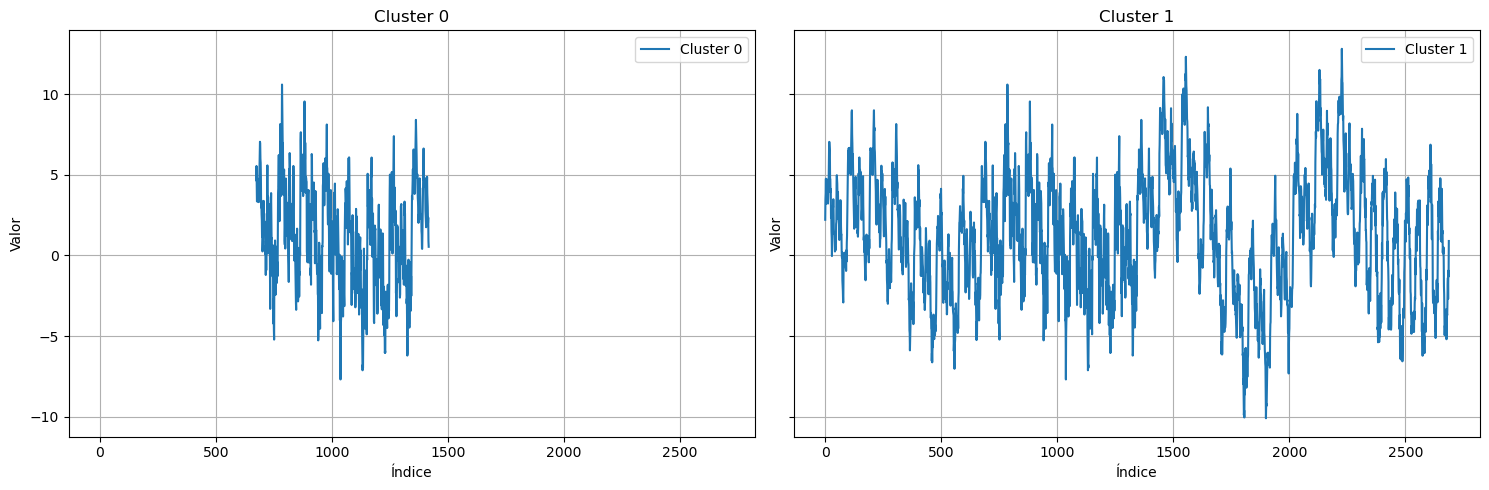

In [100]:
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

## Trying with convolutional

In [109]:
from scipy.signal import convolve

In [119]:
def dataframe_convolve_column(
    df, 
    colname,
    kernel_mean = [1/3, 1/3, 1/3],
    verbose = 0
):
    series = df[colname]
    mean_smoothed = convolve(series, kernel_mean, mode = 'same')
    kernel_var = [-1, 2, -1]
    var_smoothed = convolve(series, kernel_var, mode = 'same')
    if verbose > 0:
        print("Moving mean: ", mean_smoothed)
        print("Moving var: ", var_smoothed)
    df[colname+'_mean_smoothed'] = mean_smoothed
    df[colname+'_var_smoothed'] = var_smoothed
    return mean_smoothed, var_smoothed

In [121]:
df.columns

Index(['Seasonal time series w/ noise', 'segment', 'segment_smoothed_value',
       'segment_reexpanded_smoothed_value', 'smoothed_value',
       'reexpanded_smoothed_value',
       'Seasonal time series w/ noise_mean_smoothed',
       'Seasonal time series w/ noisevar_smoothed',
       'Seasonal time series w/ noise_var_smoothed'],
      dtype='object')

In [120]:
dataframe_convolve_column(
    df,
    'Seasonal time series w/ noise',
    verbose = 1
)
    

Moving mean:  [ 1.89703541  3.18465362  4.03381664 ... -1.65058501 -0.4531548
 -0.13863577]
Moving var:  [ 0.94120053  0.88705107 -0.51288603 ...  2.12108374 -2.57198195
  3.09963173]


(array([ 1.89703541,  3.18465362,  4.03381664, ..., -1.65058501,
        -0.4531548 , -0.13863577]),
 array([ 0.94120053,  0.88705107, -0.51288603, ...,  2.12108374,
        -2.57198195,  3.09963173]))

In [122]:
df.columns

Index(['Seasonal time series w/ noise', 'segment', 'segment_smoothed_value',
       'segment_reexpanded_smoothed_value', 'smoothed_value',
       'reexpanded_smoothed_value',
       'Seasonal time series w/ noise_mean_smoothed',
       'Seasonal time series w/ noisevar_smoothed',
       'Seasonal time series w/ noise_var_smoothed'],
      dtype='object')

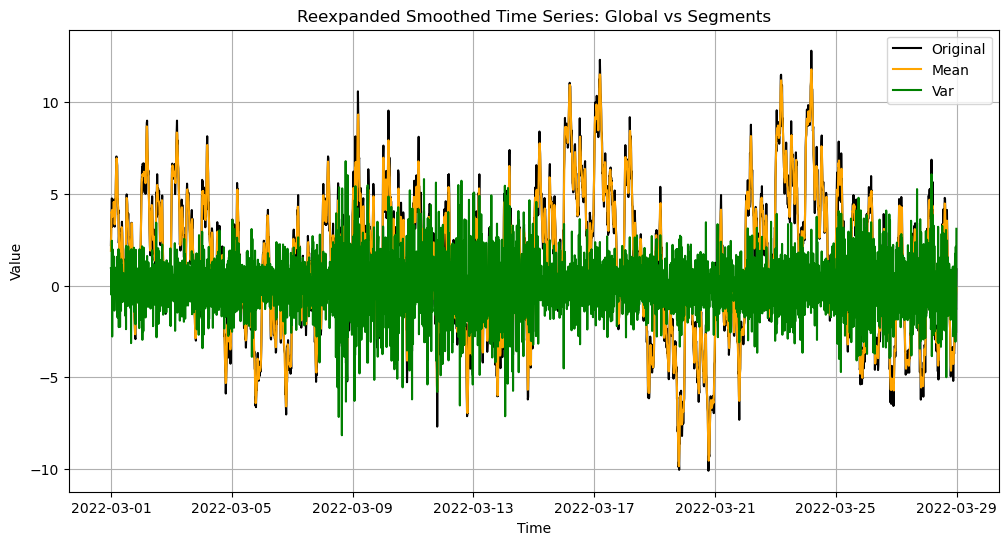

In [125]:
# Visualización
plt.figure(figsize=(12, 6))

# Serie original
plt.plot(df.index, df['Seasonal time series w/ noise'], label="Original", color='black')

# Suavizado global (reexpandido)
plt.plot(df.index, df['Seasonal time series w/ noise_mean_smoothed'], label="Mean", color='orange')
plt.plot(df.index, df['Seasonal time series w/ noise_var_smoothed'], label="Var", color='green')

plt.title("Reexpanded Smoothed Time Series: Global vs Segments")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


In [148]:
result = fine_tune_moment_(
    X                             = df['Seasonal time series w/ noise_mean_smoothed'],
    enc_learn                     = enc_learner, 
    stride                        = 1,      
    batch_size                    = enc_run.config['batch_size'],
    cpu                           = False, 
    to_numpy                      = True, 
    verbose                       = 0, 
    time_flag                     = False,
    #n_windows                     = 32,
    #n_windows_percent             = 0.8, # Enmascaro el parte del entrenamiento
    window_mask_percent           = 0.75,
    training_percent              = 0.3, # Entreno con parte de los datos
    validation_percent            = 0.3, # Evalúo con parte de los datos
    num_epochs                    = 1,
    shot                          = True,
    eval_pre                      = False,
    eval_post                     = False,
    lr_scheduler_flag             = False,
    #lr_scheduler_name             = "",
    lr                            = 1e-3,
    lr_scheduler_num_warmup_steps = 0,
    window_sizes                  = [54,72, 300],
    n_window_sizes                = 5,
    full_dataset                  = True,
    window_sizes_offset           = 0.05,
    windows_min_distance          = 5,
    print_to_path                 = False,
    print_path                    ="~/data/logs.txt",
    print_mode                    = 'w',
    use_moment_masks              = False,
    mask_stateful                 = enc_run.config['mask_stateful'],
    mask_future                   = enc_run.config['mask_future'],
    mask_sync                     = enc_run.config['mask_sync']
)

[0] fine_tune_moment_single | Train | wlen 96


  0%|          | 0/49 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 72


  0%|          | 0/50 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 8


  0%|          | 0/51 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 300


  0%|          | 0/45 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 48


  0%|          | 0/50 [00:00<?, ?it/s]

In [134]:
result = fine_tune_moment_(
    X                             = df['Seasonal time series w/ noise_var_smoothed'],
    enc_learn                     = enc_learner, 
    stride                        = 1,      
    batch_size                    = enc_run.config['batch_size'],
    cpu                           = False, 
    to_numpy                      = True, 
    verbose                       = 0, 
    time_flag                     = False,
    #n_windows                     = 32,
    #n_windows_percent             = 0.8, # Enmascaro el parte del entrenamiento
    window_mask_percent           = 0.75,
    training_percent              = 0.8, # Entreno con parte de los datos
    validation_percent            = 0.8, # Evalúo con parte de los datos
    num_epochs                    = 1,
    shot                          = True,
    eval_pre                      = False,
    eval_post                     = False,
    lr_scheduler_flag             = False,
    #lr_scheduler_name             = "",
    lr                            = 1e-3,
    lr_scheduler_num_warmup_steps = 0,
    window_sizes                  = [54,72, 300],
    n_window_sizes                = 5,
    full_dataset                  = True,
    window_sizes_offset           = 0.05,
    windows_min_distance          = 5,
    print_to_path                 = False,
    print_path                    ="~/data/logs.txt",
    print_mode                    = 'w',
    use_moment_masks              = False,
    mask_stateful                 = enc_run.config['mask_stateful'],
    mask_future                   = enc_run.config['mask_future'],
    mask_sync                     = enc_run.config['mask_sync']
)


[0] fine_tune_moment_single | Train | wlen 2


  0%|          | 0/135 [00:00<?, ?it/s]

[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution failed | Output none 
[-1] fine_tune_moment_train_loop_step_ | Execution 

  0%|          | 0/131 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 8


  0%|          | 0/135 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 300


  0%|          | 0/120 [00:00<?, ?it/s]

[0] fine_tune_moment_single | Train | wlen 16


  0%|          | 0/134 [00:00<?, ?it/s]

In [149]:
enc_learner = result[-1]
embs = get_enc_embs_set_stride_set_batch_size(
    X          = enc_input, 
    enc_learn  = enc_learner, 
    stride     = enc_run.config['stride'],
    **get_embs_kwargs
)
#embs_smoothed = get_enc_embs_set_stride_set_batch_size(
#    X          = enc_input_smoothed, 
#    enc_learn  = enc_learner, 
#    stride     = enc_run.config['stride'],
#    **get_embs_kwargs
#)
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
#embs_smoothed_no_nan = embs_smoothed[~np.isnan(embs_smoothed).any(axis=1)]

[1] --> get_enc_embs_set_stride_set_batch_size
[1] get_enc_embs_set_stride_set_batch_size | Moment | True
[1] get_acts_moment | Trial 1 | x_enc ~ torch.Size([2617, 1, 72])
[1] get_acts_moment | Trial 1 | embs ~ torch.Size([2617, 1, 9, 512])
[1] get_enc_embs_set_stride_set_batch_size | Before moving to CPU | embs~(2617, 512)
[1] get_enc_embs_set_stride_set_batch_size | embs~(2617, 512) -->


[-1  0  1]
Shape de los índices calculados: (2617, 72)


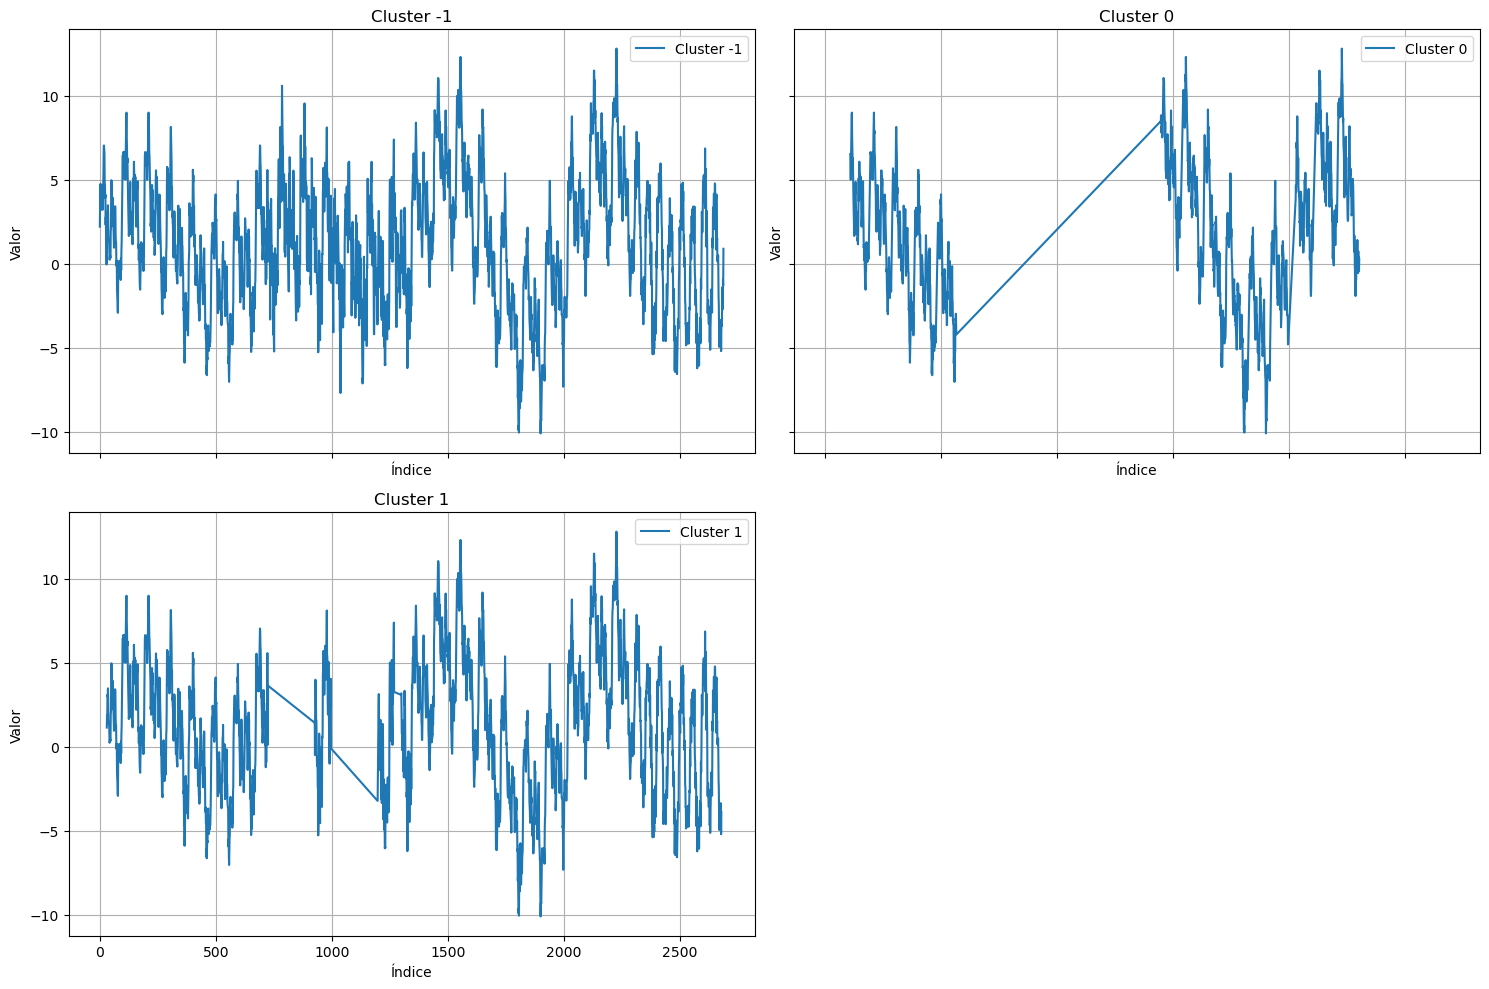

In [163]:
umap_params = {
    #'n_neighbors' : config_dr.n_neighbors,
    'n_neighbors' : 100,
    'min_dist' : 0.01,
    #'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}
pca_params = {
    'copy'  : False,
    'handle': None,
    'iterate_power' : 15,
    'n_components': 12,
    'random_state': 1234,
    'svd_solver' : 'auto',
    'tol': 1e-07,
    #'verbose': False,
    #'whiten': False,
    #'output_type': 'input'
}

prjs          = get_PCA_prjs(
    X = embs_no_nan, 
    n_components=30,
    random_state =1234
    #cpu=False, 
    #check_memory_usage = False,
   # verbose = 2,
    #**pca_params
    #pca_kwargs = pca_params,
    #umap_kwargs = umap_params
)

    
#prjs_smoothed = get_PCA_UMAP_prjs(
#    embs_smoothed_no_nan, 
#    cpu=False, 
#    pca_kwargs = pca_params,
#    umap_kwargs = umap_params
#)
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 100,
    'min_samples' : 15,
    'cluster_selection_epsilon' : 0.01,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
#clusters_smoothed = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_smoothed)
clusters_labels = clusters.labels_
#clusters_smoothed_labels = clusters.labels_
print(np.unique(clusters_labels))
plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])
#plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

In [145]:
all(clusters_labels == clusters_smoothed_labels)

True

In [168]:
umap_params = {
    #'n_neighbors' : config_dr.n_neighbors,
    'n_neighbors' : 100,
    'min_dist' : 0.01,
    #'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}
pca_params = {
    'copy'  : False,
    'handle': None,
    'iterate_power' : 15,
    'n_components': 4,
    'random_state': 1234,
    'svd_solver' : 'auto',
    'tol': 1e-07,
    #'verbose': False,
    #'whiten': False,
    #'output_type': 'input'
}

prjs          = get_PCA_UMAP_prjs(
    input_data = embs_no_nan, 
    cpu=False, 
    check_memory_usage = False,
    verbose = 2,
    pca_kwargs = pca_params,
    umap_kwargs = umap_params
)


prjs          = get_PCA_prjs(
    X = embs_no_nan, 
    cpu=False, 
    check_memory_usage = False,
    verbose = 2,
    **pca_params
)

hdbscan_kwargs = {
    'min_cluster_size' : 100,
    'min_samples' : 15,
    'cluster_selection_epsilon' : 0.001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
#clusters_smoothed = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_smoothed)
clusters_labels = clusters.labels_
#clusters_smoothed_labels = clusters.labels_
print(np.unique(clusters_labels))
print(np.unique(prjs))
plot_time_series_clusters(df['Seasonal time series w/ noise'], prjs, enc_run.config['stride'], enc_run.config['w'])
#plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_labels, enc_run.config['stride'], enc_run.config['w'])
#plot_time_series_clusters(df['Seasonal time series w/ noise'], clusters_smoothed_labels, enc_run.config['stride'], enc_run.config['w'])

About to compute PCA input_data~(2617, 512)
[I] [22:44:43.262761] Unused keyword parameter: iterate_power during cuML estimator initialization
PCA prjs~(2617, 4)
About to compute UMAP
--> get_UMAP_prjs
kwargs:  {'n_neighbors': 100, 'min_dist': 0.01, 'random_state': 1234}
4a00338ddc189df485fcea97608e44d4
GPU | Used mem: 0
GPU | Used mem: 48
GPU | Memory Usage: [--------------------] 0%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7f36715d0bd0>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 100, 'n_components': 2, 'n_epochs': None, 'learning_rate': 1.0, 'min_dist': 0.01, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'spectral', 'a': 1.8956058659900246, 'b': 0.8006378439765344, 'target_n_neighbors': -1, 'target_weight': 0.5, 'target_metric': 'categorical', 'hash_input': False, 'random_state': 1234, 'callback'

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f3a02932b90> (for post_execute):


ValueError: Image size of 1500x2617000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1500x2617000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x2.617e+06 with 777 Axes>

In [175]:
from cuml import PCA

Etiquetas de clusters únicas: [-1]


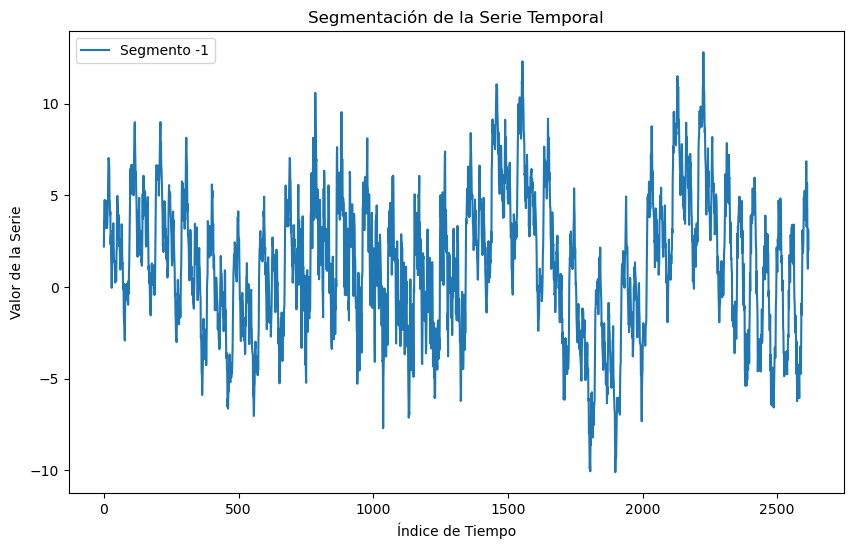

In [181]:
from cuml.decomposition import PCA
import hdbscan
import numpy as np
import matplotlib.pyplot as plt


# Reducción de dimensionalidad con PCA
pca_params = {
    'n_components': 4,
    'random_state': 1234
}
pca = PCA(**pca_params)
prjs = pca.fit_transform(embs_no_nan)  # Proyecciones en 4D

# Clustering con HDBSCAN
hdbscan_kwargs = {
    'min_cluster_size': 100,  # Ajustar según el tamaño de tus segmentos
    'min_samples': 15,
    'cluster_selection_epsilon': 0.001,
}
metric_kwargs = {'metric': 'euclidean'}

clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_  # Etiquetas de clusters

# Visualización
print("Etiquetas de clusters únicas:", np.unique(clusters_labels))

# Asignar colores a los segmentos
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(clusters_labels):
    segment_points = np.where(clusters_labels == cluster_id)[0]
    plt.plot(segment_points, df['Seasonal time series w/ noise'].iloc[segment_points], label=f'Segmento {cluster_id}')
plt.legend()
plt.title("Segmentación de la Serie Temporal")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor de la Serie")
plt.show()
